# Import the Libraries

- randomly sample r from multivariate normal mean cov
- sample r what would be result
- w_1 = (1+r) w_0 / (sum(numerator)
-

In [ ]:
dqn_action_df = pd.DataFrame()
weights_p1_df = pd.DataFrame()
weights_dqn_df = pd.DataFrame()
dqn_reward_df = pd.DataFrame()
policy1_reward_df = pd.DataFrame()

p1_weights = dqn_weights = init_state(n_assets=n_asset) # current state
for tc in tc_list:
    p_reward = []
    dqn_reward = []
    dqn_action = []
    weights_p1_list = []
    weights_dqn_list = []

    for i in range(N):
        ret = sample_return(mu=mu, cov=cov) # return sampled
        # Policy1
        next_state_policy = optimal_weight  # always rebalance
        reward_policy1 = cost_turnover(w0=p1_weights, w1=next_state_policy, tc=tc) # incur tc for rebalancing
        reward_policy1 += opt_obj

        # DQN
        # take action
        model = dqn_models[f"TC: {tc * 1e4:.0f} bps"]
        qval = model(torch.FloatTensor(dqn_weights)).detach().numpy()
        action = (env.action_space[qval.argmax()]).item()


        # rebalance
        if action == 1:
            next_state_dqn = optimal_weight # rebalance to optimal
            reward_dqn = cost_turnover(w0=dqn_weights, w1=next_state_dqn, tc=tc) # incur tc for rebalancing
            reward_dqn += opt_obj
        # no rebalance
        else:
            next_state_dqn = dqn_weights
            # reward_dqn = cost_turnover(w0=dqn_weights, w1=next_state_dqn, tc=tc) # incur no tc for rebalancing (should be 0)
            reward_dqn = obj_func(x=next_state_dqn, mu=mu, cov=cov)


        # move weights based on market movement
        #Policy1
        p1_weights = adjust_weights(r=ret, w=next_state_policy)

        # DQN
        dqn_weights = adjust_weights(r=ret, w=next_state_dqn)

        # store values
        p_reward.append(reward_policy1)
        dqn_reward.append(reward_dqn)
        dqn_action.append(action)
        weights_p1_list.append(p1_weights)
        weights_dqn_list.append(dqn_weights)


    # store in df
    policy1_reward_df[f"TC: {tc * 1e4:.0f} bps"] = p_reward
    dqn_reward_df[f"TC: {tc * 1e4:.0f} bps"] = dqn_reward
    weights_p1_df[f"TC: {tc * 1e4:.0f} bps"] = weights_p1_list
    weights_dqn_df[f"TC: {tc * 1e4:.0f} bps"] = weights_dqn_list
    dqn_action_df[f"TC: {tc * 1e4:.0f} bps"] = dqn_action

    # reset for next tc
    p_reward = []
    dqn_reward = []
    weights_p1_list = []
    weights_dqn_list = []
    dqn_action = []

In [122]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.subplots as sp
import numpy as np
from scipy.optimize import minimize
from DP_Binary import *
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from DQN_Binary.PortfolioRebalancerEnv_Roy import PortfolioRebalancerEnv

import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.express as px

from sklearn.metrics import confusion_matrix
sns.set_theme()

In [2]:
plt.rcParams.update({"font.size": 18})
tmp_device = torch.device("cpu")

In [3]:
og_path = os.getcwd()
og_path

'/Users/Roy/Desktop/College/GeorgiaTech/Research/Portfolio-Rebalancing-DQN'

# Initialize

In [4]:
n_asset = 2

In [5]:
mu = np.linspace(50, 200, n_asset) / 1e4
sigma = np.linspace(300, 800, n_asset) / 1e4
cov = np.diag(sigma ** 2)

In [6]:
tc_list = [0, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05]

In [7]:
x = np.arange(1, 101)
state_possible = np.array(np.meshgrid(*([x] * n_asset))).T.reshape(-1, n_asset).astype(np.float32)
state_possible = state_possible[state_possible.sum(axis=1) == 100, :] / 100

In [8]:
def net_sharpe(w1, mu, cov, w0, tc):
    return (w1.dot(mu) - cost_turnover(w0, w1, tc)) / np.sqrt(w1.dot(cov).dot(w1.T))


def obj_func(x, mu, cov):
    return -x.dot(mu) / np.sqrt(x.dot(cov).dot(x))

def find_optimal_wgt(mu, cov):

    n = len(mu)
    w_min = np.zeros(n)
    w_max = np.ones(n) * 2 / n
    x0 = np.ones(n) / n
    bounds = np.vstack([w_min, w_max]).T

    cstr = [{"type": "eq", "fun": lambda x: np.sum(x) - 1, "jac": lambda x: np.ones(n)}]
    opt = minimize(fun=obj_func, x0=x0, args=(mu, cov),
                   bounds=bounds,
                   constraints=cstr,
                   tol=1e-6,
                   options={"maxiter": 10000})

    if not opt.success:
        raise ValueError("optimization failed: {}".format(opt.message))

    return opt.x / opt.x.sum()


def cost_turnover(w0, w1, tc):
    return np.sum(np.abs(w1 - w0) * tc) / 2


def expected_cost_total(w0, w1, opt_w, mu, cov, tc):
    opt_net_sharpe = net_sharpe(opt_w, mu, cov, w0, tc)
    w1_net_sharpe = net_sharpe(w1, mu, cov, w0, tc)
    return opt_net_sharpe - w1_net_sharpe

# DP

In [9]:
dp_path = og_path + '/DP/results/models/'
os.chdir(dp_path)

In [10]:
df_0 = pd.read_csv("dp_tc_0_assets_2", index_col=0, dtype=np.float32)
df_01 = pd.read_csv("dp_tc_0.001_assets_2", index_col=0, dtype=np.float32)
df_02 = pd.read_csv("dp_tc_0.002_assets_2", index_col=0, dtype=np.float32)
df_05 = pd.read_csv("dp_tc_0.0005_assets_2", index_col=0, dtype=np.float32)
df_5 = pd.read_csv("dp_tc_0.005_assets_2", index_col=0, dtype=np.float32)
df_1 = pd.read_csv("dp_tc_0.01_assets_2", index_col=0, dtype=np.float32)
df_5 = pd.read_csv("dp_tc_0.05_assets_2", index_col=0, dtype=np.float32)

In [11]:
df_list = [df_0, df_05, df_01, df_02, df_5, df_1, df_5]

In [12]:
x = pd.to_numeric(df_0.index.values)
action_possible = pd.to_numeric(df_0.columns.values)

In [13]:
action_df = pd.DataFrame(index=x)
action_bm_df = pd.DataFrame(index=x)
for tc, bell in zip(tc_list, df_list):
    # visualize q table
    action = np.array([action_possible[i] for i in np.argmax(bell, axis=1)])
    action_df[f"TC: {tc * 1e4:.0f} bps BM"] = action
    action_bm = []
    for i in x:
        a = x[np.argmax([net_sharpe(np.array([j, 1 - j]), mu, cov, np.array([i, 1 - i]), tc) for j in x])] - i
        action_bm.append(a)
    action_bm = np.array(action_bm)
    action_bm_df[f"TC: {tc * 1e4:.0f} bps BM (GT)"] = action_bm

In [14]:
optimal_weight = find_optimal_wgt(mu, cov)
optimal_weight

array([0.63941273, 0.36058727])

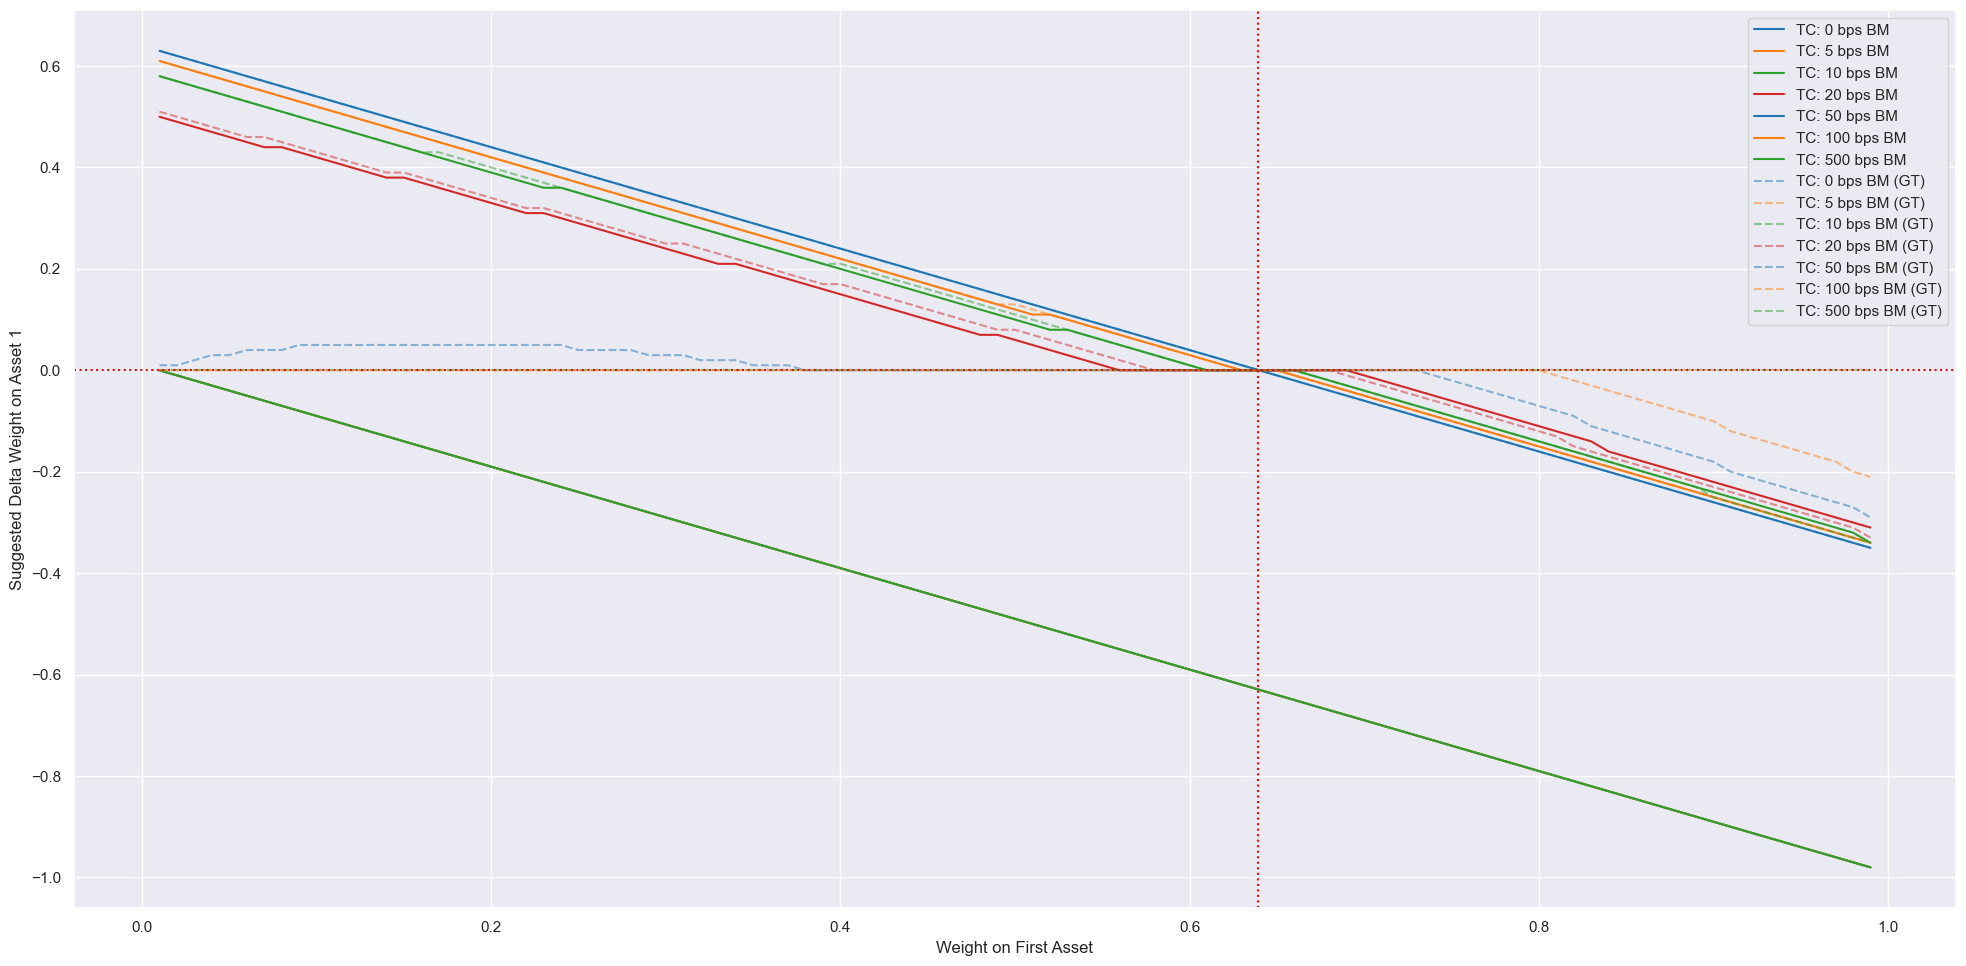

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
action_bm_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed", alpha=0.5)
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()
plt.close()


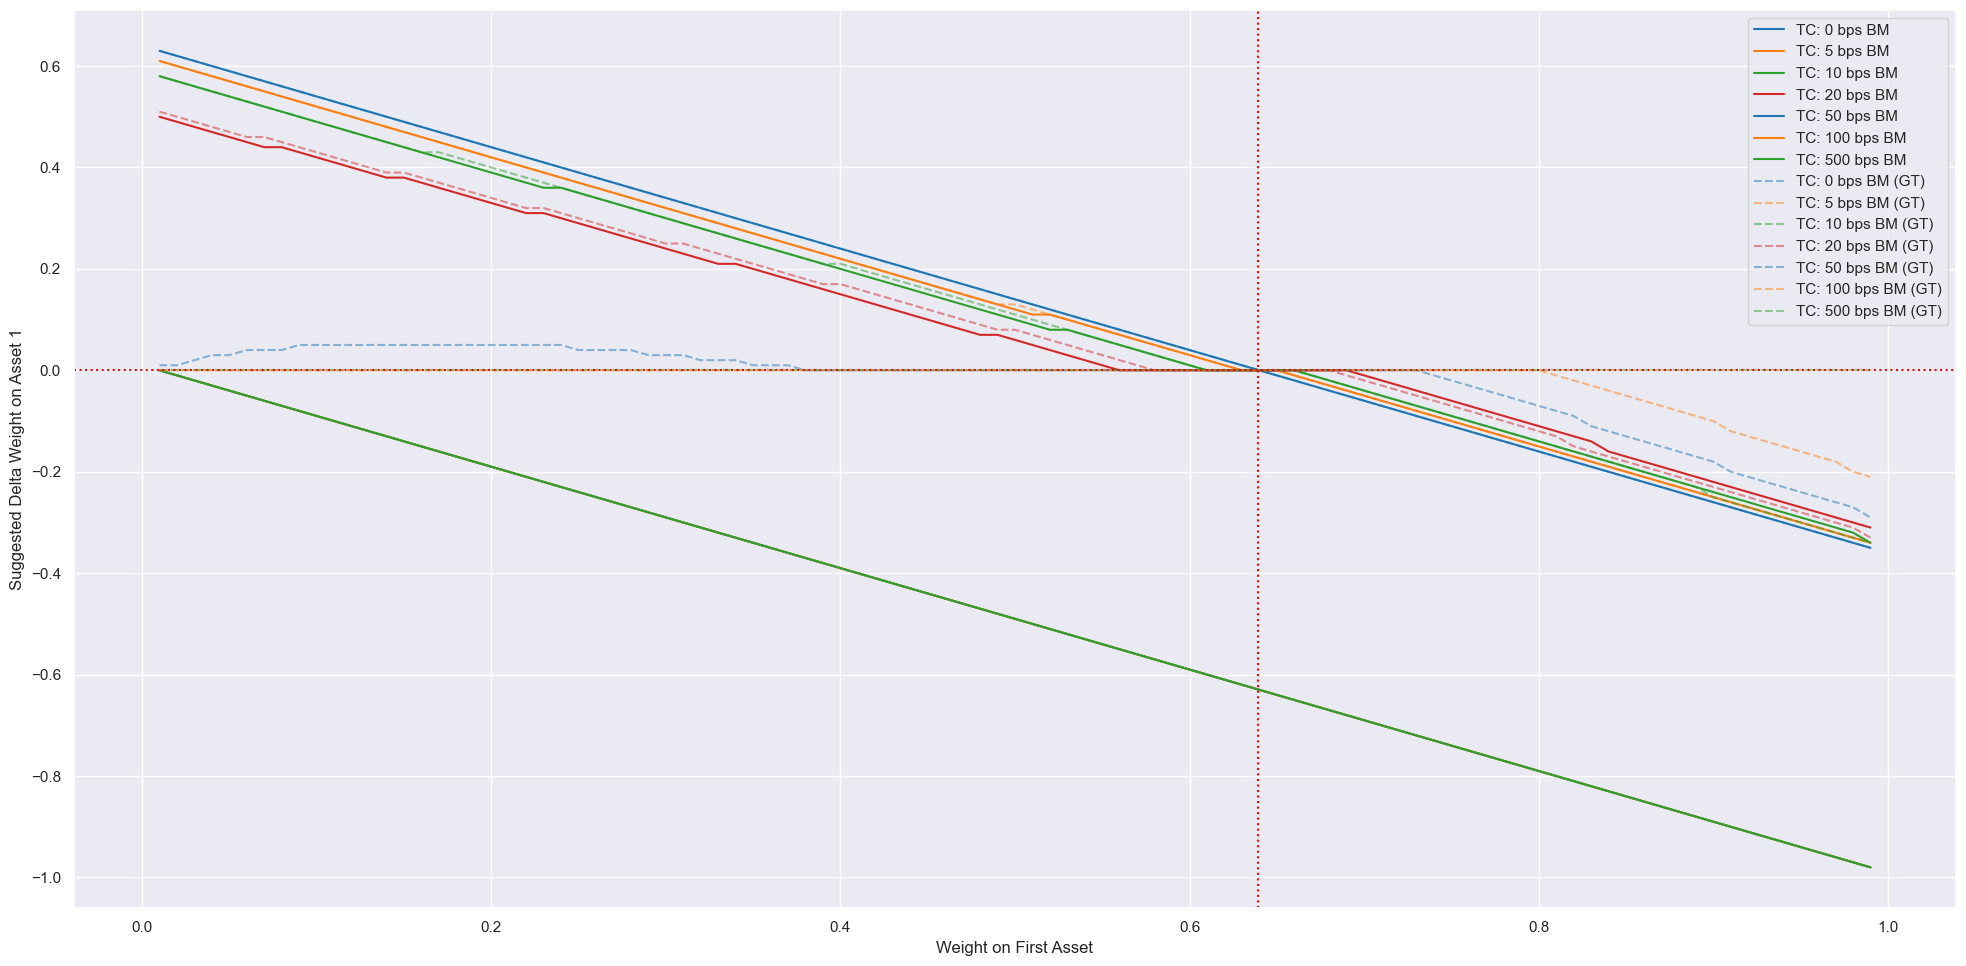

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
action_bm_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed", alpha=0.5)
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()
plt.close()


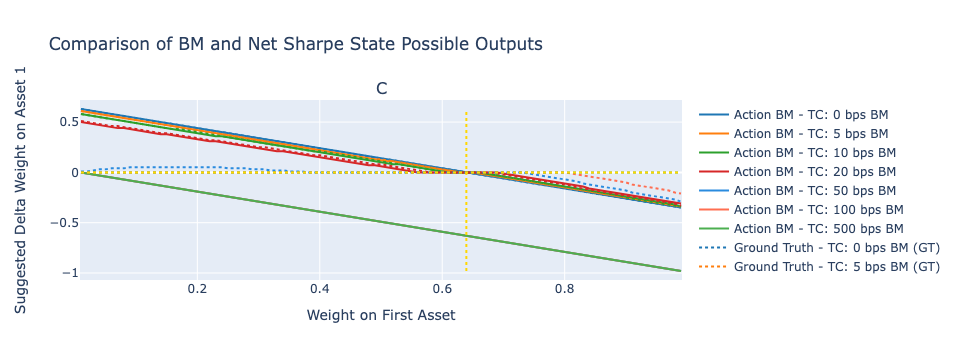

In [17]:
# Create subplots
fig = sp.make_subplots(rows=1, cols=1, subplot_titles="Comparison of BM and Net Sharpe State Possible Outputs", shared_yaxes=True)

# Add traces for Action DQN and Action BM
for col, color, linestyle in zip(action_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['solid']*len(action_df.columns)):
    trace_dqn = go.Scatter(x=action_df.index, y=action_df[col], mode='lines', name=f'Action BM - {col}', line=dict(color=color, dash="solid"))
    fig.add_trace(trace_dqn, row=1, col=1)

# Add traces for Action DQN and Action BM
for col, color, linestyle in zip(action_bm_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['dot']*len(action_bm_df.columns)):
    trace_bm = go.Scatter(x=action_bm_df.index, y=action_bm_df[col], mode='lines', name=f'Ground Truth - {col}', line=dict(color=color, dash=linestyle))
    fig.add_trace(trace_bm, row=1, col=1)

# Add vertical and horizontal lines
fig.add_shape(dict(
    type="line",
    x0=optimal_weight[0],
    x1=optimal_weight[0],
    y0=action_df.values.min(),
    y1=action_df.values.max(),
    line=dict(color="gold", dash="dot")
))

fig.add_shape(dict(
    type="line",
    x0=action_df.index.min(),
    x1=action_df.index.max(),
    y0=0,
    y1=0,
    line=dict(color="gold", dash="dot")
))

# Update layout
fig.update_layout(
    title="Comparison of BM and Net Sharpe State Possible Outputs",
    xaxis=dict(title="Weight on First Asset"),
    yaxis=dict(title="Suggested Delta Weight on Asset 1"),
    showlegend=True,
)

# Show the figure
fig.show()


- Change DP ground truth to run on binary (check)
- DQN still weird need debug with higher TC (in progress)
- Decision boundary changed so need to re-run DP (check)
- Use Bar Graph for plotting (TBD)

# DP Binary

In [18]:
dp_path = og_path + '/DP_Binary/results/models/'
os.chdir(dp_path)

In [19]:
df_0 = pd.read_csv("dp_tc_0_assets_2", index_col=0, dtype=np.float32)
df_01 = pd.read_csv("dp_tc_0.001_assets_2", index_col=0, dtype=np.float32)
df_02 = pd.read_csv("dp_tc_0.002_assets_2", index_col=0, dtype=np.float32)
df_05 = pd.read_csv("dp_tc_0.0005_assets_2", index_col=0, dtype=np.float32)
df_5 = pd.read_csv("dp_tc_0.005_assets_2", index_col=0, dtype=np.float32)
df_1 = pd.read_csv("dp_tc_0.01_assets_2", index_col=0, dtype=np.float32)
df_5 = pd.read_csv("dp_tc_0.05_assets_2", index_col=0, dtype=np.float32)

In [20]:
df_list = [df_0, df_05, df_01, df_02, df_5, df_1, df_5]

In [21]:
x = pd.to_numeric(df_0.index.values)
action_possible = pd.to_numeric(df_0.columns.values)

In [22]:
action_df = pd.DataFrame(index=x)
action_bm_df = pd.DataFrame(index=x)
for tc, bell in zip(tc_list, df_list):
    # visualize q table
    action = np.array([action_possible[i] for i in np.argmax(bell, axis=1)])
    action_df[f"TC: {tc * 1e4:.0f} bps BM"] = action
    action_bm = []
    for i in x:
        a = x[np.argmax([net_sharpe(np.array([j, 1 - j]), mu, cov, np.array([i, 1 - i]), tc) for j in x])] - i
        action_bm.append(a)
    action_bm = np.array(action_bm)
    action_bm_df[f"TC: {tc * 1e4:.0f} bps BM (GT)"] = action_bm

In [23]:
optimal_weight = find_optimal_wgt(mu, cov)
optimal_weight

array([0.63941273, 0.36058727])

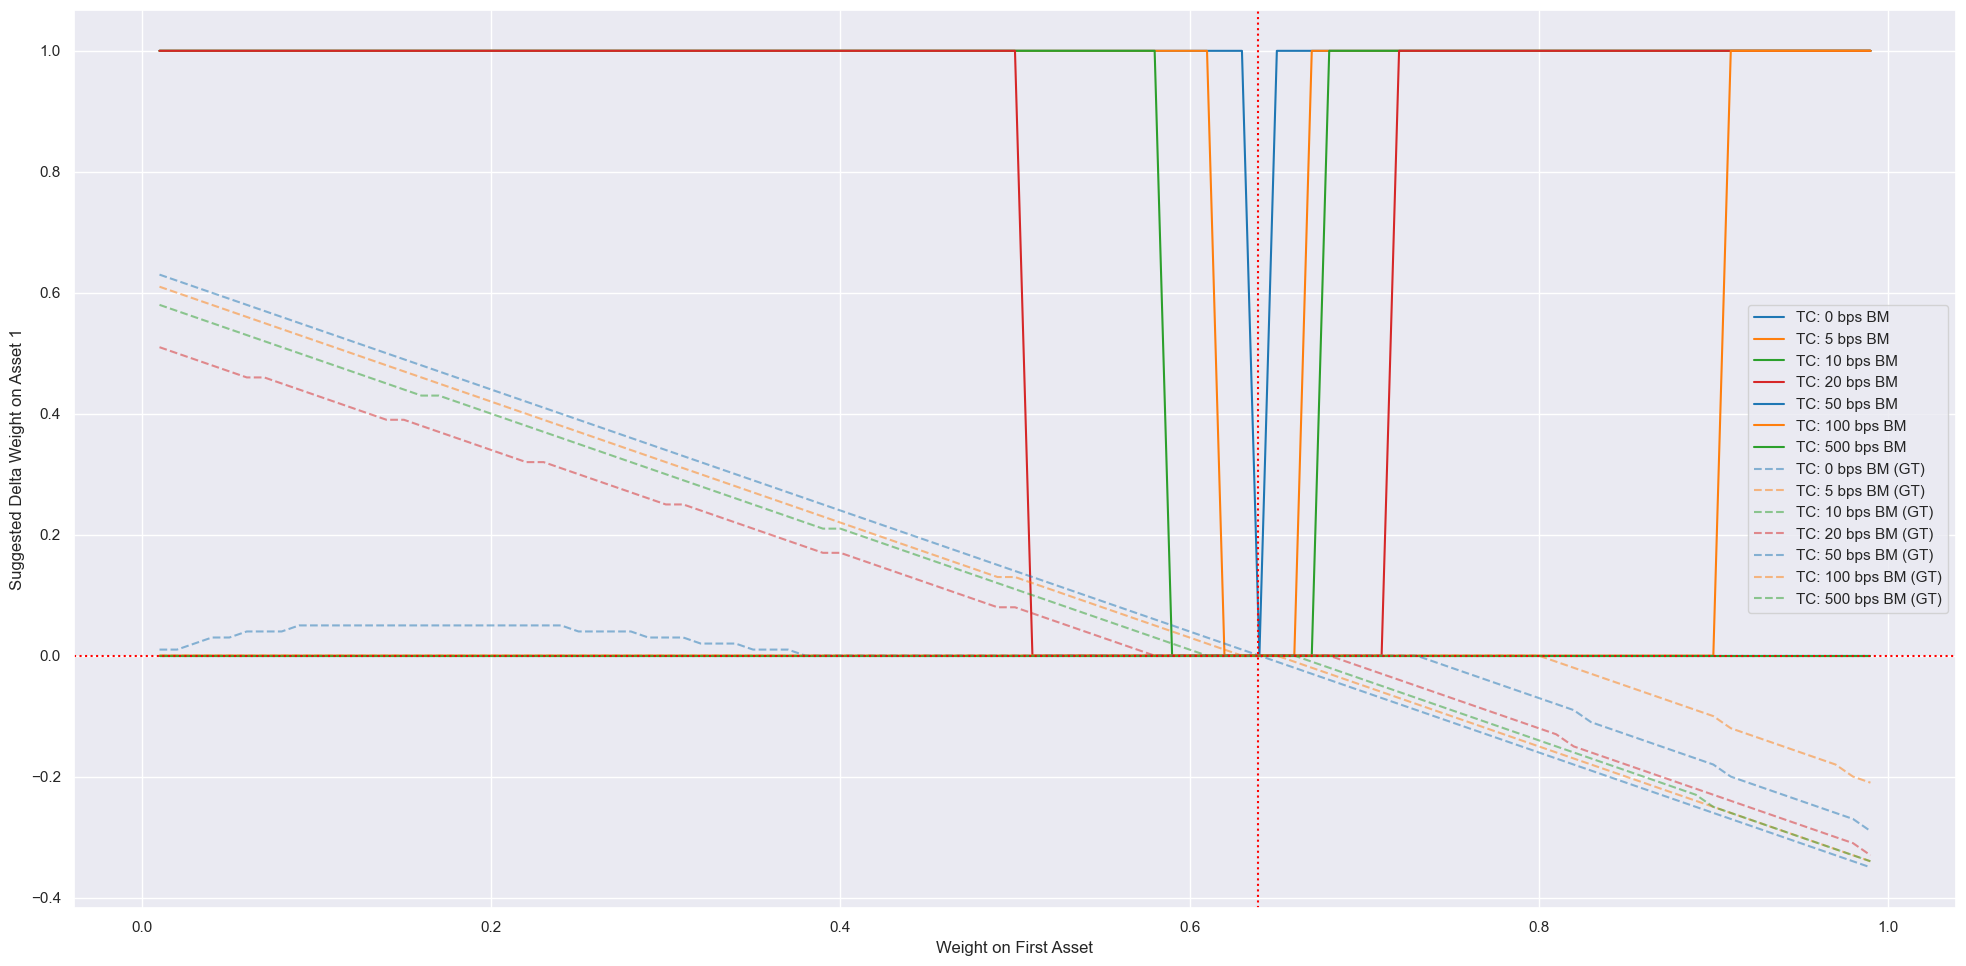

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
action_bm_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed", alpha=0.5)
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()
plt.close()


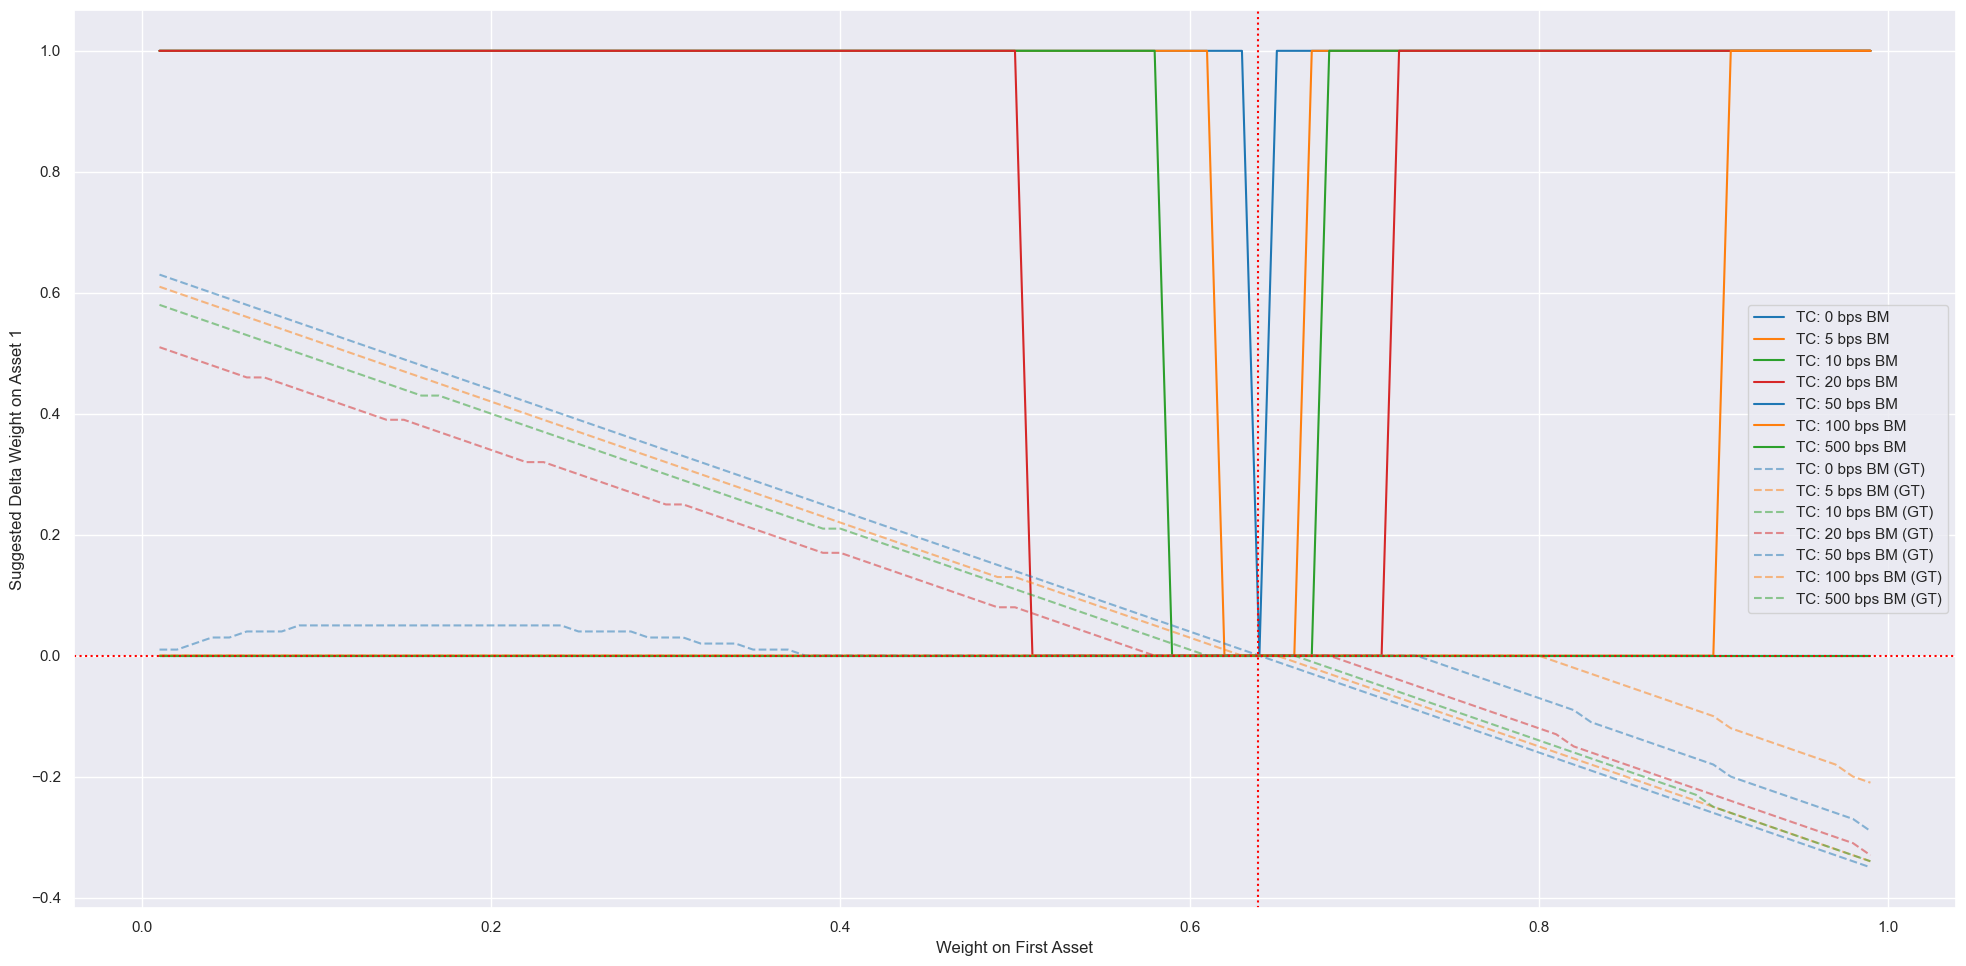

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
action_bm_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed", alpha=0.5)
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()
plt.close()


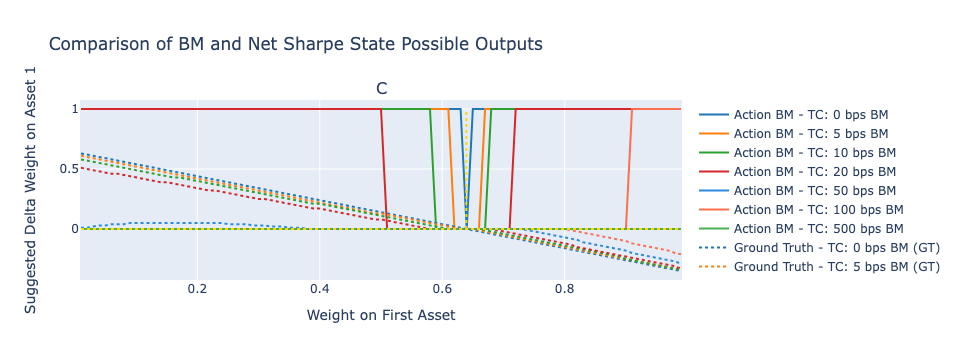

In [26]:
# Create subplots
fig = sp.make_subplots(rows=1, cols=1, subplot_titles="Comparison of BM and Net Sharpe State Possible Outputs", shared_yaxes=True)

# Add traces for Action DQN and Action BM
for col, color, linestyle in zip(action_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['solid']*len(action_df.columns)):
    trace_dqn = go.Scatter(x=action_df.index, y=action_df[col], mode='lines', name=f'Action BM - {col}', line=dict(color=color, dash="solid"))
    fig.add_trace(trace_dqn, row=1, col=1)

# Add traces for Action DQN and Action BM
for col, color, linestyle in zip(action_bm_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['dot']*len(action_bm_df.columns)):
    trace_bm = go.Scatter(x=action_bm_df.index, y=action_bm_df[col], mode='lines', name=f'Ground Truth - {col}', line=dict(color=color, dash=linestyle))
    fig.add_trace(trace_bm, row=1, col=1)

# Add vertical and horizontal lines
fig.add_shape(dict(
    type="line",
    x0=optimal_weight[0],
    x1=optimal_weight[0],
    y0=action_df.values.min(),
    y1=action_df.values.max(),
    line=dict(color="gold", dash="dot")
))

fig.add_shape(dict(
    type="line",
    x0=action_df.index.min(),
    x1=action_df.index.max(),
    y0=0,
    y1=0,
    line=dict(color="gold", dash="dot")
))

# Update layout
fig.update_layout(
    title="Comparison of BM and Net Sharpe State Possible Outputs",
    xaxis=dict(title="Weight on First Asset"),
    yaxis=dict(title="Suggested Delta Weight on Asset 1"),
    showlegend=True,
)

# Show the figure
fig.show()


# DDPG

## TODO: Need to run DDPG for two asset case only

In [27]:
# ddpg_path = og_path + '/DDPG/'
# os.chdir(ddpg_path)

In [28]:
# from DDPG import *

In [29]:
# ddpg_action_df = pd.DataFrame(index=state_possible[:, 0])
# for tc in tc_list:
#     agent = Agent(alpha=0.01, beta=0.01, input_dims=[n_asset], tau=0.01, tc=tc,
#                   batch_size=100000, layer1_size=400, layer2_size=300, n_actions=n_asset)
#     agent.load_models()
#     action = []
#     for current_state in state_possible:
#         tmp_action = agent.choose_action(current_state)
#         action.append(tmp_action[0])  # just store action of first asset

#     action = np.array(action)
#     ddpg_action_df[f"TC: {tc * 1e4:.0f} bps"] = action

In [30]:
# ddpg_action_df

# DQN Binary

- run with decreasing learning rate
- run for few hours
- - 10_000_000 epochs
  - 

In [31]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions, name, tc, chkpt_dir='results/models'):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, n_actions)

        self.checkpoint_file = os.path.join(chkpt_dir, name + f'_tc_{tc}_assets_{n_observations}_dqn')

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file, map_location=torch.device('cpu')))

In [32]:
def save_models(pn, tn):
    pn.save_checkpoint()
    tn.save_checkpoint()

def load_models(pn, tn):
    pn.load_checkpoint()
    tn.load_checkpoint()

In [33]:
ddpg_path = og_path + '/DQN_Binary/'
os.chdir(ddpg_path)

In [34]:
optimal_weight = find_optimal_wgt(mu, cov)
optimal_weight

array([0.63941273, 0.36058727])

In [35]:
env = PortfolioRebalancerEnv(
    mu=mu,
    sigma=cov,
    w_optimal=optimal_weight,
    n_assets=n_asset,
)
# device = torch.device("cpu")

In [36]:
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.9999
EPS_END = 0.05
EPS_DECAY = 1_000
TAU = 0.005
LR = 1e-4
mem_cap = 10_000
mode = 'FF'
num_episodes = 50_000

In [37]:
x = np.arange(1, 101)
state_possible = np.array(np.meshgrid(*([x] * 2))).T.reshape(-1, 2).astype(
    np.float32)
state_possible = state_possible[state_possible.sum(axis=1) == 100, :] / 100

In [38]:
dqn_bool_action_df = pd.DataFrame(index=x)

In [39]:
x = state_possible[:, 0]
dqn_action_df = pd.DataFrame(index=x)
for tc in tc_list:
    a = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)
    b = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)

    load_models(pn=a, tn=b)

    # visualize q table
    action = []
    for j in range(x.shape[0]):
        qval = a(torch.FloatTensor(state_possible[j])).detach().numpy()
        action.append(env.action_space[qval.argmax()])

    action = np.array(action)
    dqn_action_df[f"TC: {tc * 1e4:.0f} bps"] = action

dqn_action_df

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


TC: 0 bps  TC: 5 bps  TC: 10 bps  TC: 20 bps  TC: 50 bps  TC: 100 bps  \
0.01          1          1           1           1           0            0   
0.02          1          1           1           1           0            0   
0.03          1          1           1           1           0            0   
0.04          1          1           1           1           0            0   
0.05          1          1           1           1           0            0   
...         ...        ...         ...         ...         ...          ...   
0.95          1          1           1           1           1            1   
0.96          1          1           1           1           1            1   
0.97          1          1           1           1           1            1   
0.98          1          1           1           1           1            1   
0.99          1          1           1           1           1            1   

      TC: 500 bps  
0.01            0  
0.02            0  
0.03            0  
0.04            0  
0.05            0  
...           ...  
0.95            0  
0.96            0  
0.97            0  
0.98            0  
0.99            0  

[99 rows x 7 columns]

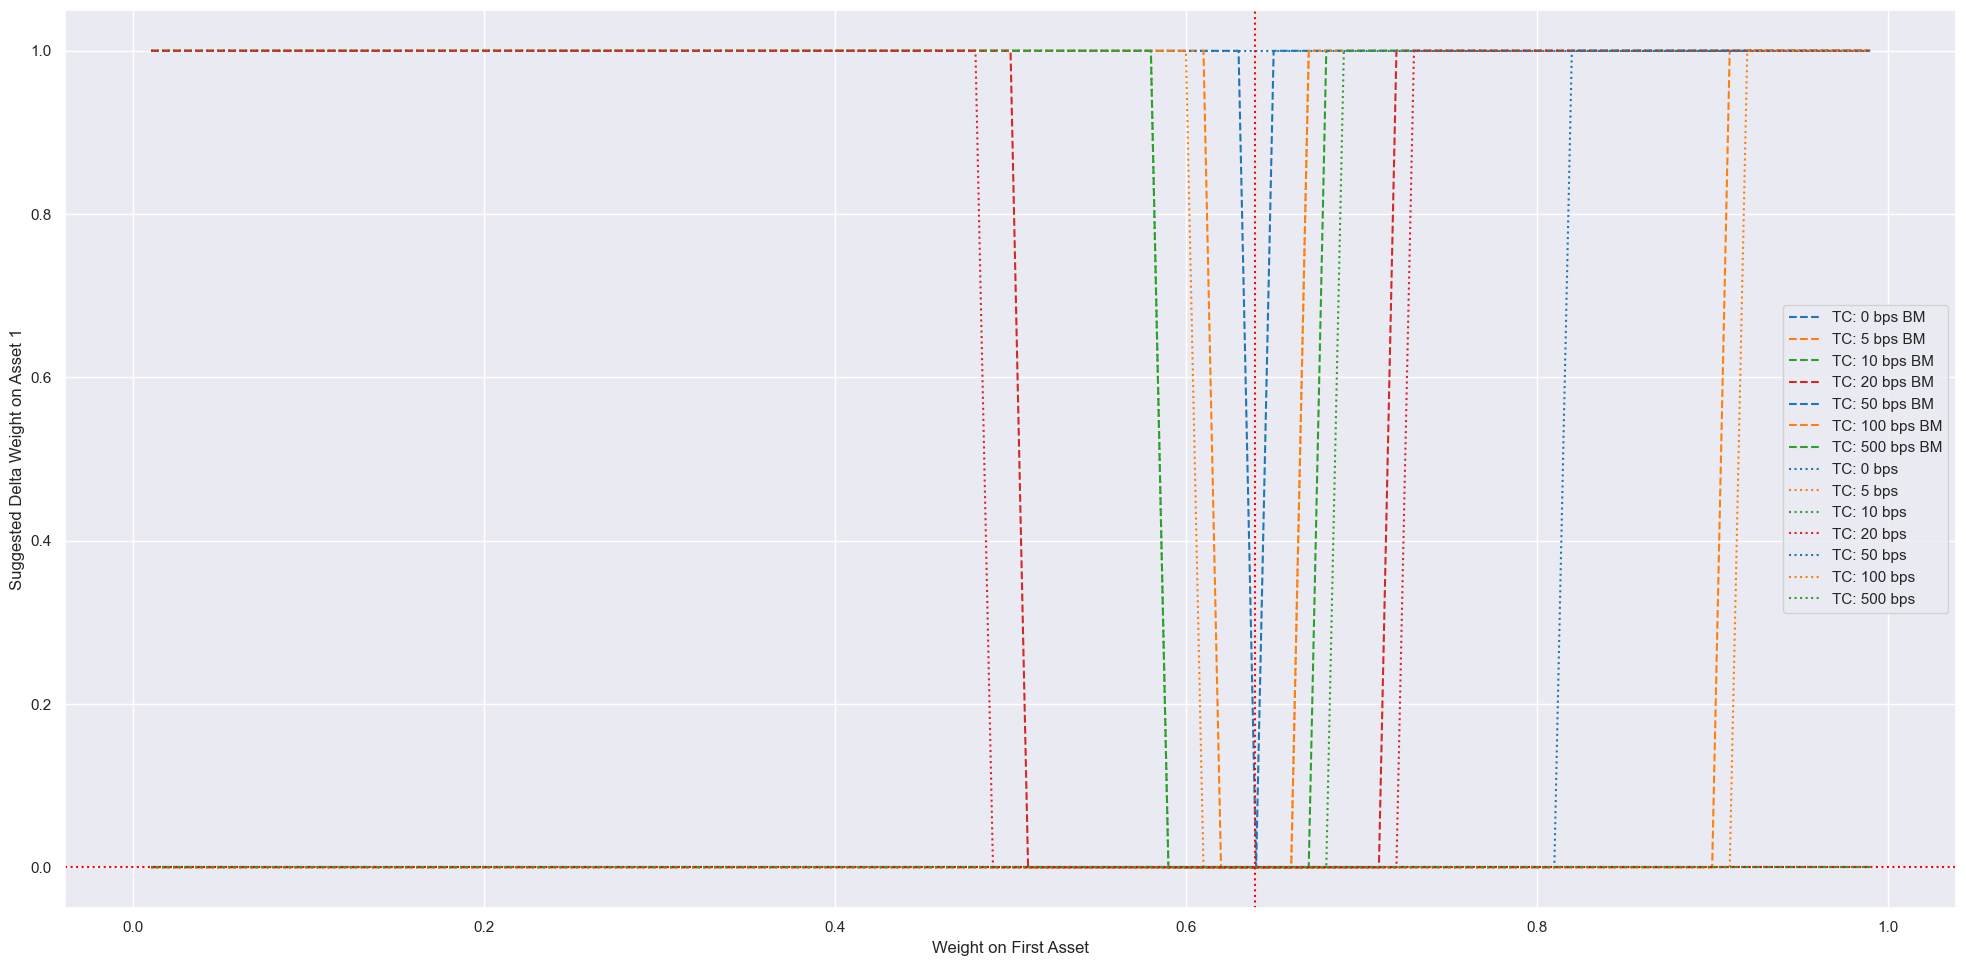

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
dqn_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dotted")
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()

## Visualize Results

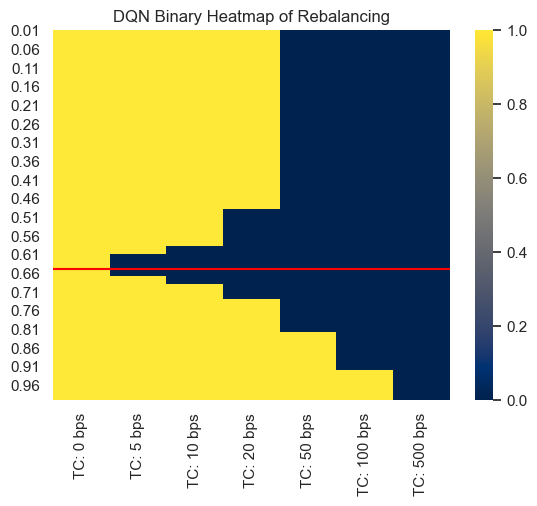

In [41]:
sns.heatmap(dqn_action_df, cmap='cividis')

y = optimal_weight[0]
ax = plt.gca()
plt.hlines(y=y*100, xmin=0, xmax=len(dqn_action_df.columns), colors='red')
plt.title("DQN Binary Heatmap of Rebalancing")
plt.show()

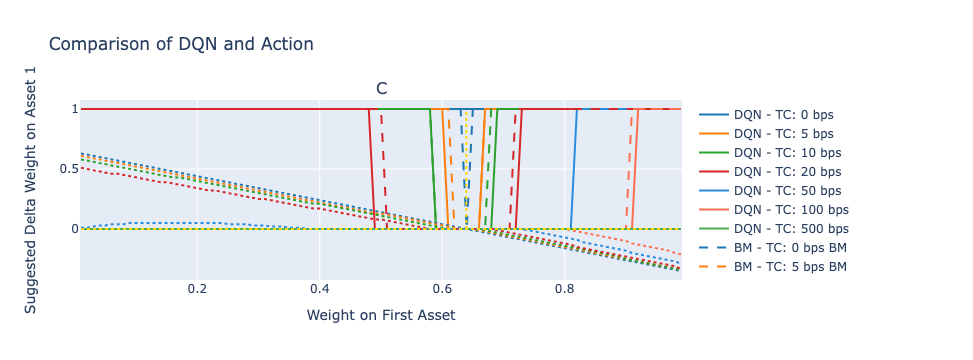

In [42]:

# Assuming `dqn_bool_action_df`, `action_df`, and `optimal_weight` are available

# Create subplots
fig = sp.make_subplots(rows=1, cols=1, subplot_titles=("Comparison of DQN and Action"), shared_yaxes=True)

# Add traces for DQN and Action
for col, color, linestyle in zip(dqn_action_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['solid']*len(dqn_action_df.columns)):
    trace_dqn = go.Scatter(x=dqn_action_df.index, y=dqn_action_df[col], mode='lines', name=f'DQN - {col}', line=dict(color=color, dash=linestyle))
    fig.add_trace(trace_dqn, row=1, col=1)

# Add traces for DQN and Action
for col, color, linestyle in zip(action_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['dash']*len(action_df.columns)):
    trace_action = go.Scatter(x=action_df.index, y=action_df[col], mode='lines', name=f'BM - {col}', line=dict(color=color, dash=linestyle))
    fig.add_trace(trace_action, row=1, col=1)

# Add traces for Action DQN and Action BM
for col, color, linestyle in zip(action_bm_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['dot']*len(action_bm_df.columns)):
    trace_bm = go.Scatter(x=action_bm_df.index, y=action_bm_df[col], mode='lines', name=f'Ground Truth - {col}', line=dict(color=color, dash=linestyle))
    fig.add_trace(trace_bm, row=1, col=1)

# Add vertical and horizontal lines
fig.add_shape(dict(
    type="line",
    x0=optimal_weight[0],
    x1=optimal_weight[0],
    y0=action_df.values.min(),
    y1=action_df.values.max(),
    line=dict(color="gold", dash="dot")
))

fig.add_shape(dict(
    type="line",
    x0=dqn_action_df.index.min(),
    x1=dqn_action_df.index.max(),
    y0=0,
    y1=0,
    line=dict(color="gold", dash="dot")
))

# Update layout
fig.update_layout(
    title="Comparison of DQN and Action",
    xaxis=dict(title="Weight on First Asset"),
    yaxis=dict(title="Suggested Delta Weight on Asset 1"),
    showlegend=True,
)

# Show the figure
fig.show()


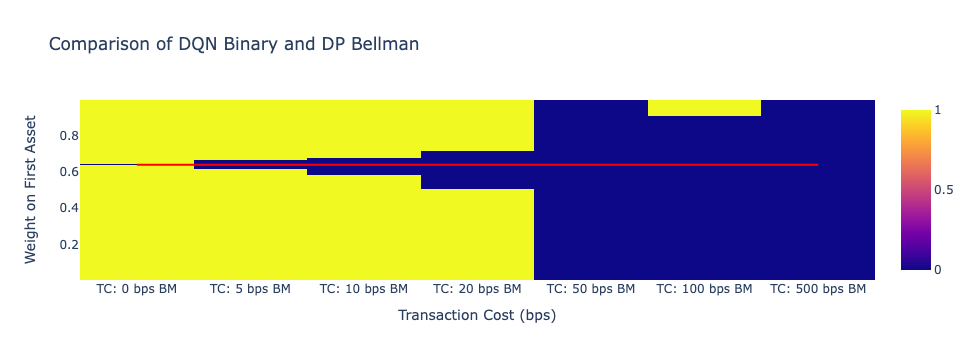

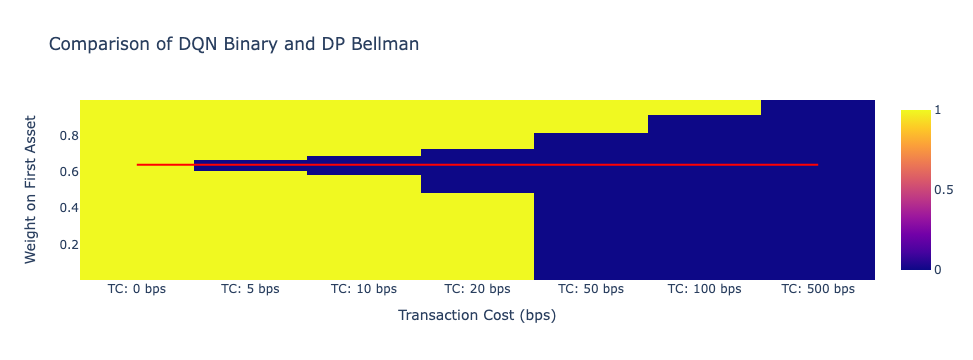

In [43]:
# Assuming `dqn_bool_action_df` and `bool_action_bm_df` are your DataFrames
dqn_df = dqn_action_df.copy()
bm_df = action_df.copy()

# Create a heatmap trace for DQN Binary
trace_dqn = go.Heatmap(z=dqn_df, x=dqn_df.columns, y=dqn_df.index, name="DQN Binary")

# Create a heatmap trace for DP Bellman
trace_dp = go.Heatmap(z=bm_df, x=bm_df.columns, y=bm_df.index, name="DP Bellman")

# Create a heatmap trace for Q Table
# trace_q = go.Heatmap(z=q_df, x=q_df.columns, y=q_df.index, name="Q Table")

# Create the layout with 'overlay' parameter set to "overlay"
layout = go.Layout(
    title="Comparison of DQN Binary and DP Bellman",
    xaxis=dict(title="Transaction Cost (bps)",
               showgrid=True),
    yaxis=dict(title="Weight on First Asset",
               showgrid=True))

# Add horizontal line at y=0.50
layout.shapes = [
    dict(
        type="line",
        x0=dqn_df.columns[0],  # Adjust x0 to the starting point of your data
        x1=dqn_df.columns[-1],  # Adjust x1 to the ending point of your data
        y0=optimal_weight[0],
        y1=optimal_weight[0],
        line=dict(color="red", width=2),  # You can customize the color and width of the line
    ),
    dict(
        type="line",
        x0=bm_df.columns[0],  # Adjust x0 to the starting point of your data
        x1=bm_df.columns[-1],  # Adjust x1 to the ending point of your data
        y0=optimal_weight[0],
        y1=optimal_weight[0],
        line=dict(color="red", width=2),  # You can customize the color and width of the line
    ),
    # dict(
    #     type="line",
    #     x0=q_df.columns[0],  # Adjust x0 to the starting point of your data
    #     x1=q_df.columns[-1],  # Adjust x1 to the ending point of your data
    #     y0=optimal_weight[0],
    #     y1=optimal_weight[0],
    #     line=dict(color="red", width=2))
]

# Create the figure
fig = go.Figure(data=[trace_dp], layout=layout)
fig.show()

fig = go.Figure(data=[trace_dqn], layout=layout)
fig.show()

# fig = go.Figure(data=[trace_q], layout=layout)
# fig.show()


In [44]:
# Create an empty dataframe to store the confusion matrices
confusion_matrices = {}

# Iterate through the columns and calculate confusion matrices
for col1, col2 in zip(bm_df.columns, dqn_df.columns):
    true_labels = bm_df[col1]
    predicted_labels = dqn_df[col2]

    # Create the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)
    confusion_matrices[col1] = confusion

# Print or use the confusion matrices as needed
for column, confusion in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(confusion)


Confusion Matrix for TC: 0 bps BM:
[[ 0  1]
 [ 0 98]]
Confusion Matrix for TC: 5 bps BM:
[[ 5  0]
 [ 1 93]]
Confusion Matrix for TC: 10 bps BM:
[[ 9  0]
 [ 1 89]]
Confusion Matrix for TC: 20 bps BM:
[[21  0]
 [ 3 75]]
Confusion Matrix for TC: 50 bps BM:
[[81 18]
 [ 0  0]]
Confusion Matrix for TC: 100 bps BM:
[[90  0]
 [ 1  8]]
Confusion Matrix for TC: 500 bps BM:
[[99]]


In [45]:
dqn_noreb = {}
bm_noreb = {}
for col1, col2 in zip(bm_df.columns, dqn_df.columns):
    bm_index = bm_df[bm_df[col1] == 0].index.values
    dqn_index = dqn_df[dqn_df[col2] == 0].index.values
    bm_noreb[col2] = bm_index
    dqn_noreb[col2] = dqn_index

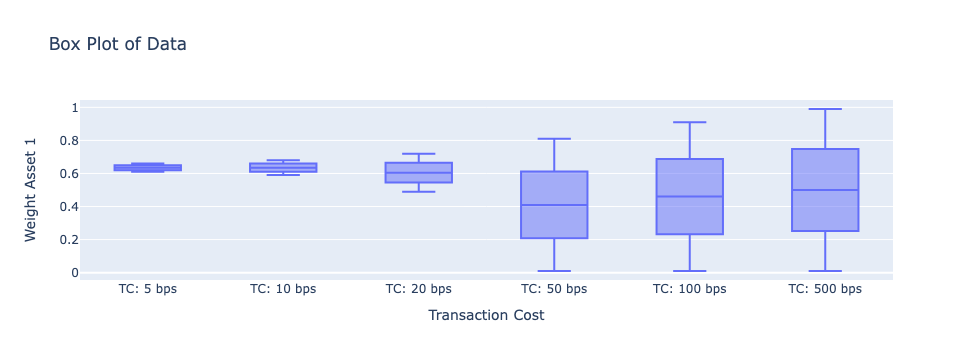

In [46]:
# Create a DataFrame from the dictionary, excluding keys with empty values
df = pd.DataFrame.from_dict(dqn_noreb, orient='index').T

# Create a box plot using Plotly
fig = px.box(df, title="Box Plot of Data").update_layout(yaxis_title="Weight Asset 1", xaxis_title="Transaction Cost")

# Show the plot
fig.show()

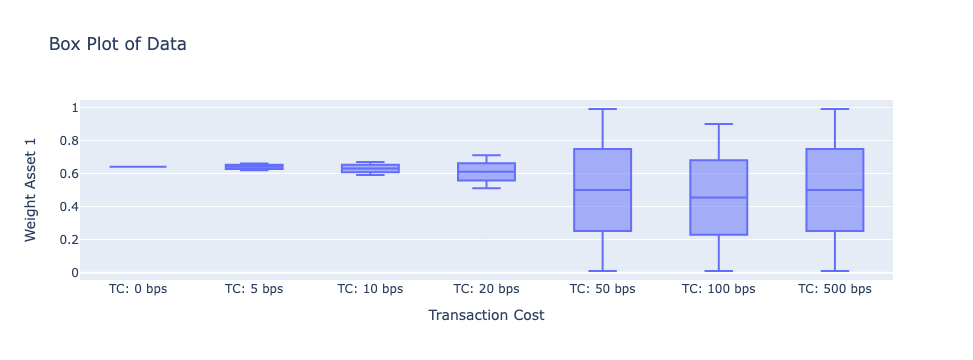

In [47]:
# Create a DataFrame from the dictionary, excluding keys with empty values
df = pd.DataFrame.from_dict(bm_noreb, orient='index').T

# Create a box plot using Plotly
fig = px.box(df, title="Box Plot of Data").update_layout(yaxis_title="Weight Asset 1", xaxis_title="Transaction Cost")

# Show the plot
fig.show()

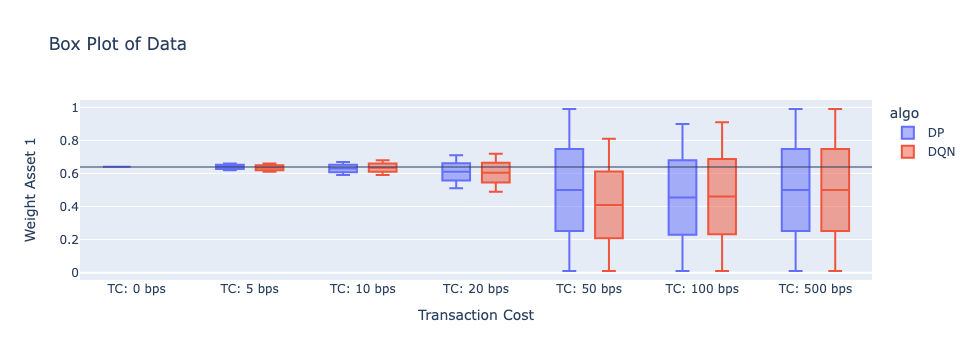

In [48]:
# Create DataFrames from the dictionaries
df_bm = pd.DataFrame.from_dict(bm_noreb, orient='index').T
df_dqn = pd.DataFrame.from_dict(dqn_noreb, orient='index').T

df_dqn['algo'] = ['DQN']*df_dqn.shape[0]
df_bm['algo'] = ['DP']*df_bm.shape[0]

# Merge the two DataFrames
df_merged = pd.concat([df_bm, df_dqn])

# Create a box plot using Plotly
fig = px.box(df_merged, title="Box Plot of Data", color='algo')\
    .update_layout(yaxis_title="Weight Asset 1", xaxis_title="Transaction Cost")

fig.add_hline(y=optimal_weight[0], opacity=0.5)

# Show the plot
fig.show()

# Higher Dimensions

## 4 Assets

In [49]:
ddpg_path = og_path + '/DQN_Binary/'
os.chdir(ddpg_path)

In [50]:
n_asset = 4
tc = 0.002
mu = np.linspace(50, 200, n_asset) / 1e4
sigma = np.linspace(300, 800, n_asset) / 1e4
cov = np.diag(sigma ** 2)

In [51]:
optimal_weight = find_optimal_wgt(mu, cov)
state = torch.Tensor(optimal_weight).unsqueeze(0)
optimal_weight

array([0.32646603, 0.26983215, 0.21982399, 0.18387782])

In [52]:
x = np.arange(1, 101)
spn = np.array(np.meshgrid(*([x] * len(mu)))).T.reshape(-1, len(mu)).astype(
    np.float32)
spn = spn[spn.sum(axis=1) == 100, :] / 100
tc_list = [0, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05]

In [53]:
x = state_possible[:, 0]
dqn_action_df = pd.DataFrame(index=x)
for tc in tc_list:
    a = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)
    b = DQN(n_observations=n_asset, n_actions=2, name="Target", tc=tc).to(tmp_device)

    load_models(pn=a, tn=b)

    # visualize q table
    action = []
    for j in range(x.shape[0]):
        qval = a(torch.FloatTensor(spn[j])).detach().numpy()
        action.append(env.action_space[qval.argmax()])

    action = np.array(action)
    dqn_action_df[f"TC: {tc * 1e4:.0f} bps"] = action

dqn_action_df

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


TC: 0 bps  TC: 5 bps  TC: 10 bps  TC: 20 bps  TC: 50 bps  TC: 100 bps  \
0.01          1          1           1           1           1            0   
0.02          1          1           1           1           1            0   
0.03          1          1           1           1           1            0   
0.04          1          1           1           1           1            0   
0.05          1          1           1           1           1            0   
...         ...        ...         ...         ...         ...          ...   
0.95          1          1           1           1           1            0   
0.96          1          1           1           1           1            0   
0.97          1          1           1           1           1            0   
0.98          1          1           1           1           1            0   
0.99          1          1           1           1           1            0   

      TC: 500 bps  
0.01            0  
0.02            0  
0.03            0  
0.04            0  
0.05            0  
...           ...  
0.95            0  
0.96            0  
0.97            0  
0.98            0  
0.99            0  

[99 rows x 7 columns]

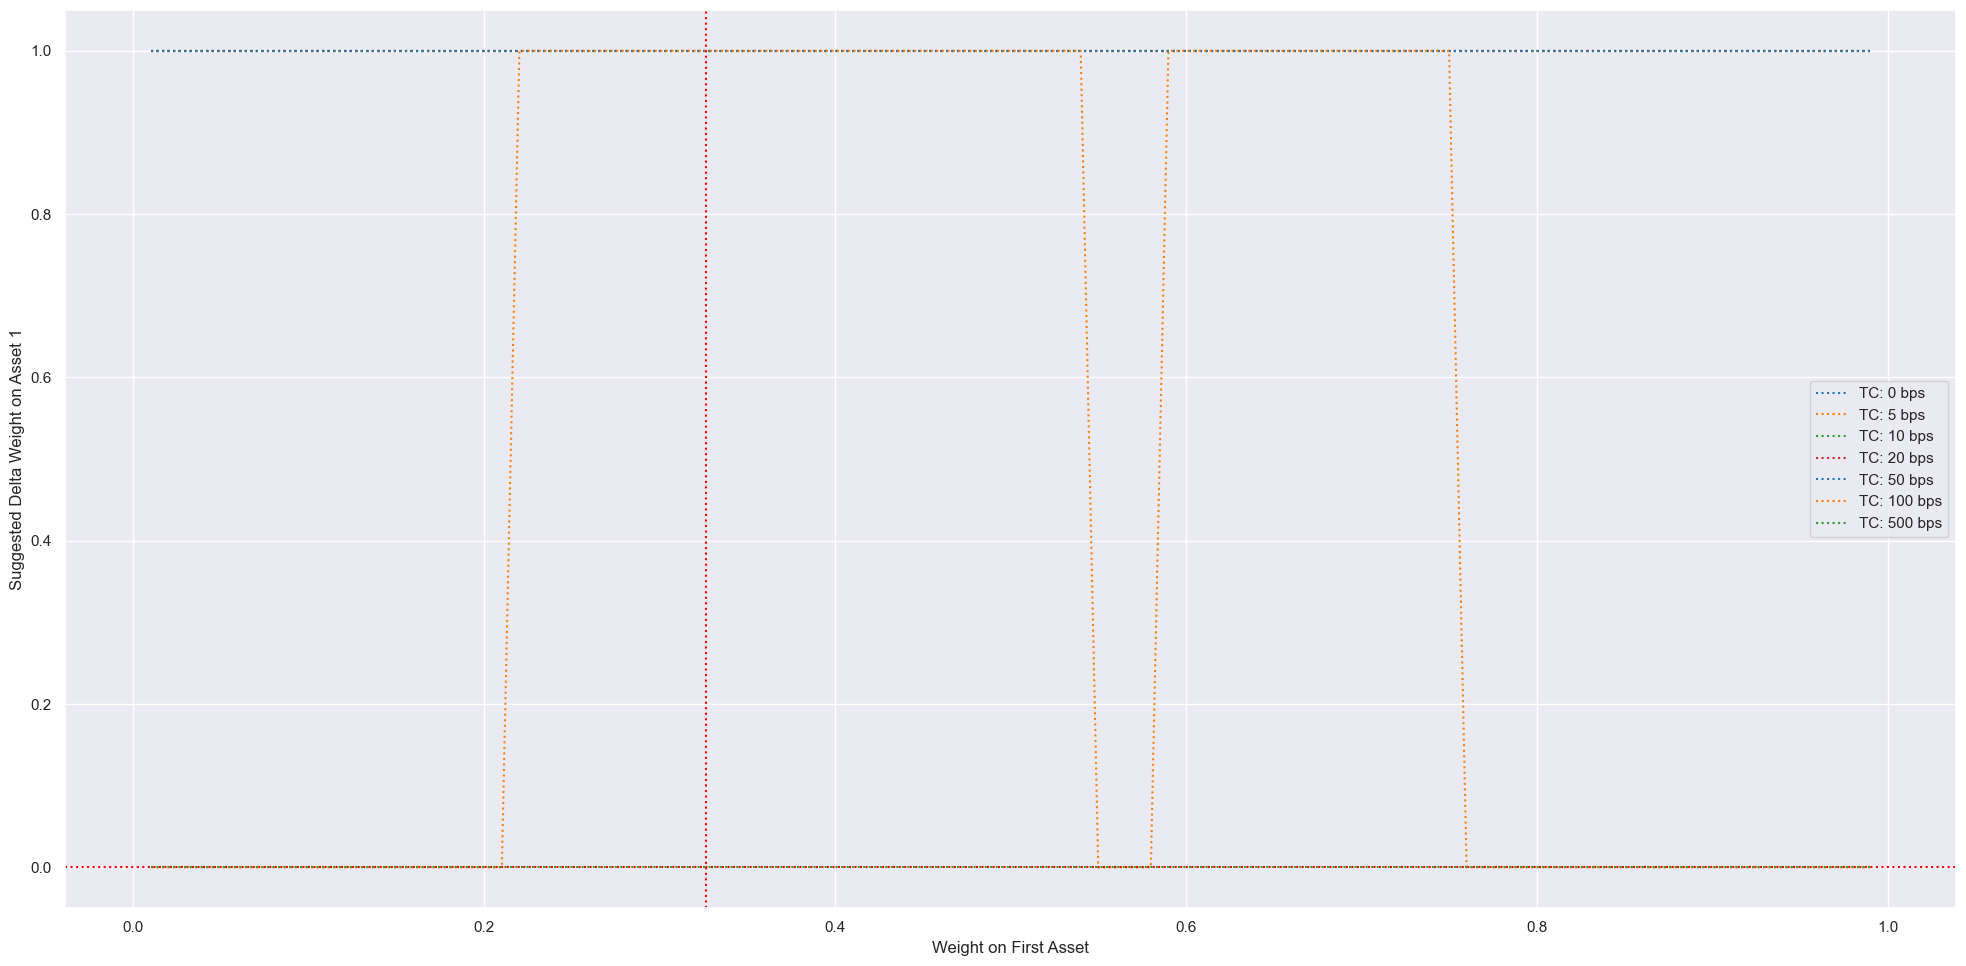

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# ql_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# bell_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
dqn_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dotted")
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()

In [55]:
def fix_reward(x):
    return [i.cpu().item() for i in x]

In [56]:
# reward_df = pd.DataFrame()
# for col, val in reward_dict.items():
#     reward_df[col] = fix_reward(reward_dict[col])

# reward_df

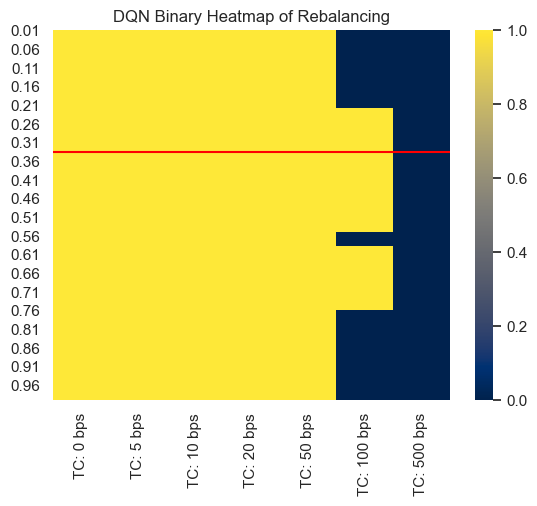

In [57]:
sns.heatmap(dqn_action_df, cmap='cividis')

y = optimal_weight[0]
ax = plt.gca()
plt.hlines(y=y*100, xmin=0, xmax=len(dqn_action_df.columns), colors='red')
plt.title("DQN Binary Heatmap of Rebalancing")
plt.show()

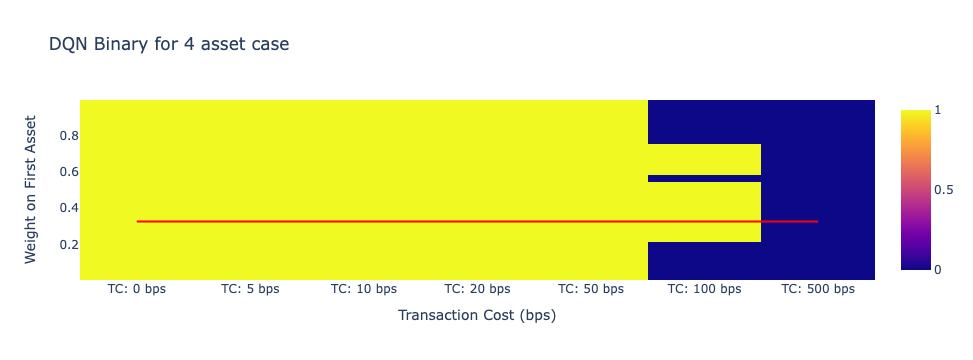

In [58]:
# Assuming `dqn_bool_action_df` and `bool_action_bm_df` are your DataFrames
dqn_df = dqn_action_df.copy()

# Create a heatmap trace for DQN Binary
trace_dqn = go.Heatmap(z=dqn_df, x=dqn_df.columns, y=dqn_df.index, name="DQN Binary")

# Create the layout with 'overlay' parameter set to "overlay"
layout = go.Layout(
    title=f"DQN Binary for {n_asset} asset case",
    xaxis=dict(title="Transaction Cost (bps)",
               showgrid=True),
    yaxis=dict(title="Weight on First Asset",
               showgrid=True))

# Add horizontal line at y=0.50
layout.shapes = [
    dict(
        type="line",
        x0=dqn_df.columns[0],  # Adjust x0 to the starting point of your data
        x1=dqn_df.columns[-1],  # Adjust x1 to the ending point of your data
        y0=optimal_weight[0],
        y1=optimal_weight[0],
        line=dict(color="red", width=2),  # You can customize the color and width of the line
    )
]


fig = go.Figure(data=[trace_dqn], layout=layout)
fig.show()



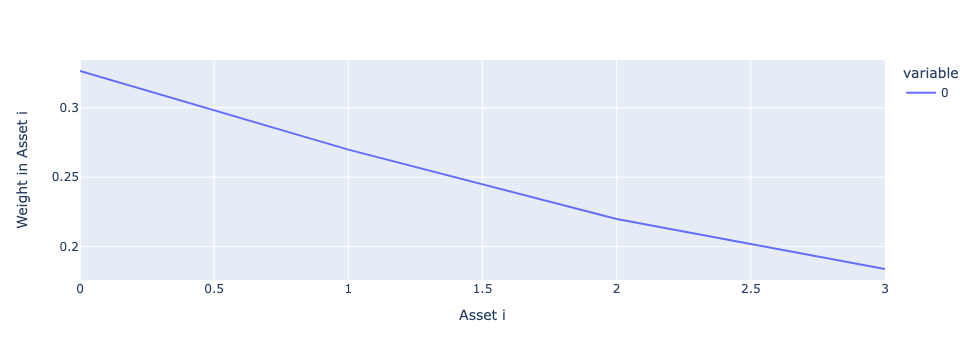

In [59]:
px.line(optimal_weight).update_layout(xaxis_title="Asset i", yaxis_title="Weight in Asset i")

In [60]:
tc = 0.002
a = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)
b = DQN(n_observations=n_asset, n_actions=2, name="Target", tc=tc).to(tmp_device)

load_models(pn=a, tn=b)

... loading checkpoint ...
... loading checkpoint ...


In [61]:
qval = a(torch.FloatTensor(optimal_weight)).detach().numpy()
act = env.action_space[qval.argmax()]
if act.item() == 1:
    print(f"Action = {act.item()} -> You should rebalance! (tc = {tc * 1e4:.0f} bps)")
else:
    print(f"Action = {act.item()} -> You should NOT rebalance! (tc = {tc * 1e4:.0f} bps)")

Action = 0 -> You should NOT rebalance! (tc = 20 bps)


In [62]:
import torch

def get_high_dim_tensors(og_tensor, w_optimal, num_steps=10):
    if type(og_tensor) != torch.Tensor:
        og_tensor = torch.Tensor(og_tensor).unsqueeze(0)
    # Calculate the increase and decrease values
    num_steps_up = num_steps // 2
    num_steps_down = num_steps - num_steps_up

    # Calculate the increase and decrease values
    increase_values = torch.linspace(0, 1 - og_tensor[0, 0], num_steps_up)
    decrease_values = torch.linspace(1 - og_tensor[0, 0], 0, num_steps_down)

    # Create a list of tensors
    result_list = []

    a = torch.zeros(og_tensor.size(1))
    a[0] = 1

    b = torch.full((og_tensor.size(1),), 1 / (og_tensor.size(1) - 1))
    b[0] = 0

    c = torch.full((og_tensor.size(1),), 1 / (og_tensor.size(1)))

    result_list.append(torch.Tensor(w_optimal))
    result_list.append(a)
    result_list.append(b)
    result_list.append(c)


    # above given state
    for i in range(num_steps_up):
        updated_tensor = og_tensor.clone()
        updated_tensor[0, 0] += increase_values[i]
        updated_tensor[0, 1:] -= (increase_values[i] / (og_tensor.size(1) - 1))
        if torch.any(torch.lt(updated_tensor, 0)):
            break
        elif torch.equal(updated_tensor.squeeze(), torch.Tensor(w_optimal)):
            continue
        else:
            result_list.append(updated_tensor.squeeze())

    decrease_values = torch.flip(decrease_values, dims=(0,))
    # below given state
    for i in range(num_steps_down):
        updated_tensor = og_tensor.clone()
        updated_tensor[0, 0] -= decrease_values[i]
        updated_tensor[0, 1:] += (decrease_values[i] / (og_tensor.size(1) - 1))
        if torch.any(torch.lt(updated_tensor, 0)):
            break
        elif torch.equal(updated_tensor.squeeze(), torch.Tensor(w_optimal)):
            continue
        else:
            result_list.append(updated_tensor.squeeze())

    return result_list


In [63]:
# og_tensor = torch.tensor([[0.1, 0.3, 0.3, 0.3]])
high_dim_tensors = get_high_dim_tensors(og_tensor=optimal_weight, w_optimal=optimal_weight, num_steps=20)
high_dim_tensors[:5]

[tensor([0.3265, 0.2698, 0.2198, 0.1839]),
 tensor([1., 0., 0., 0.]),
 tensor([0.0000, 0.3333, 0.3333, 0.3333]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor([0.4013, 0.2449, 0.1949, 0.1589])]

In [64]:
delta_weights_0 = [0] + [(-high_dim_tensors[0][0] + high_dim_tensors[1:][i][0]).item() for i in range(len(high_dim_tensors) - 1)]
delta_weights_0 = [round(i, 2) for i in delta_weights_0]
delta_weights_0[:5]

[0, 0.67, -0.33, -0.08, 0.07]

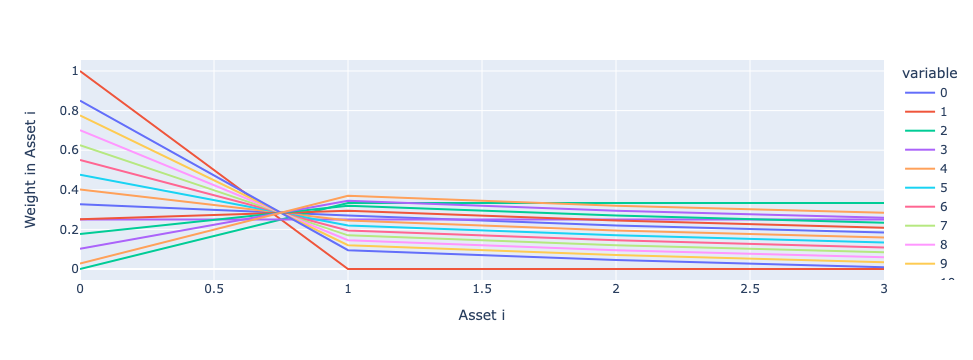

In [65]:
tmp = high_dim_tensors
tmp = [i.detach().numpy() for i in tmp]
df = pd.DataFrame(tmp).T
px.line(df).update_layout(xaxis_title="Asset i", yaxis_title="Weight in Asset i")

In [66]:
# out = []
# for i in high_dim_tensors:
#     qval = a(torch.FloatTensor(i)).detach().numpy()
#     act = env.action_space[qval.argmax()]
#     out.append(act.item())
#     if act.item() == 1:
#         print(f"Action = {act.item()} -> You should rebalance! (tc = {tc * 1e4:.0f} bps)")
#     else:
#         print(f"Action = {act.item()} -> You should NOT rebalance! (tc = {tc * 1e4:.0f} bps)")

In [67]:
out = {}
for tc in tc_list:
    a = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)
    b = DQN(n_observations=n_asset, n_actions=2, name="Target", tc=tc).to(tmp_device)
    
    load_models(pn=a, tn=b)
    tmp = []
    for i in high_dim_tensors:
        qval = a(torch.FloatTensor(i)).detach().numpy()
        act = env.action_space[qval.argmax()]
        tmp.append(act.item())

    out[f'TC:  {tc * 1e4:.0f} bps'] = tmp

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


In [68]:
df = pd.DataFrame(out, index=delta_weights_0)
df = df.sort_index()
df.head()

TC:  0 bps  TC:  5 bps  TC:  10 bps  TC:  20 bps  TC:  50 bps  \
-0.33           1           1            1            1            0   
-0.30           1           1            1            1            0   
-0.22           1           1            1            1            0   
-0.15           1           1            1            0            0   
-0.08           1           1            1            0            0   

       TC:  100 bps  TC:  500 bps  
-0.33             0             0  
-0.30             0             0  
-0.22             0             0  
-0.15             0             0  
-0.08             0             0

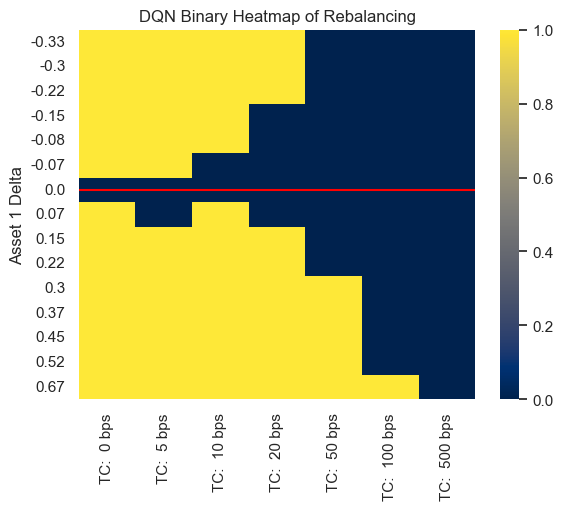

In [69]:
sns.heatmap(df, cmap='cividis')

ax = plt.gca()
plt.hlines(y=df.shape[0] // 2 - 1/2, xmin=0, xmax=len(dqn_action_df.columns), colors='red')
plt.title("DQN Binary Heatmap of Rebalancing")
plt.ylabel("Asset 1 Delta")
plt.show()

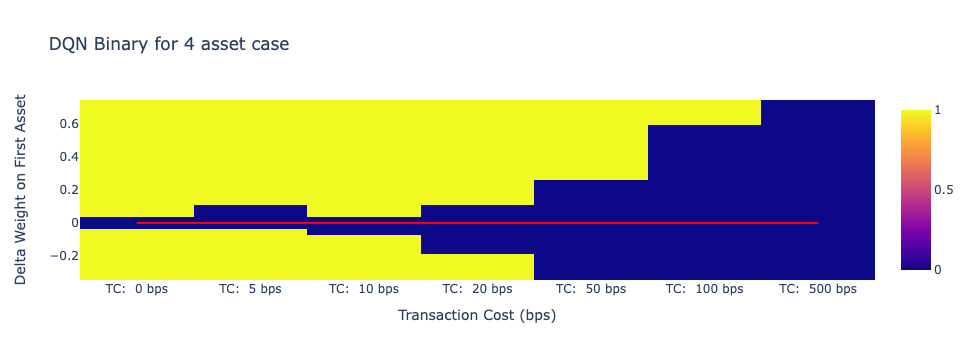

In [70]:
# Assuming `dqn_bool_action_df` and `bool_action_bm_df` are your DataFrames
dqn_df = df.copy()

# Create a heatmap trace for DQN Binary
trace_dqn = go.Heatmap(z=dqn_df, x=dqn_df.columns, y=dqn_df.index, name="DQN Binary")

# Create the layout with 'overlay' parameter set to "overlay"
layout = go.Layout(
    title=f"DQN Binary for {n_asset} asset case",
    xaxis=dict(title="Transaction Cost (bps)",
               showgrid=True),
    yaxis=dict(title="Delta Weight on First Asset",
               showgrid=True))

# Add horizontal line at y=0.50
layout.shapes = [
    dict(
        type="line",
        x0=dqn_df.columns[0],  # Adjust x0 to the starting point of your data
        x1=dqn_df.columns[-1],  # Adjust x1 to the ending point of your data
        y0=0,
        y1=0,
        line=dict(color="red", width=2),  # You can customize the color and width of the line
    )
]


fig = go.Figure(data=[trace_dqn], layout=layout)
fig.show()



In [71]:
dqn_noreb = {}
for col in df.columns:
    dqn_index = df[df[col] == 0].index.values
    dqn_noreb[col] = dqn_index

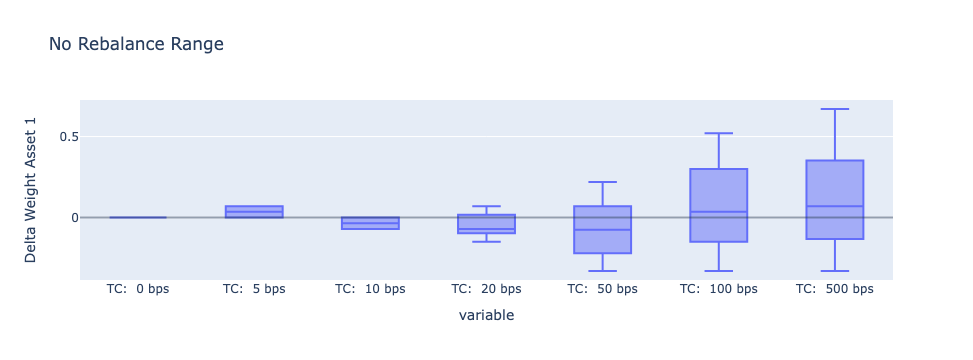

In [72]:
# Create a DataFrame from the dictionary, excluding keys with empty values
df = pd.DataFrame.from_dict(dqn_noreb, orient='index').T

# Create a box plot using Plotly
fig = px.box(df, title="No Rebalance Range").update_layout(yaxis_title="Delta Weight Asset 1")

fig.add_hline(y=0, opacity=0.5)

# Show the plot
fig.show()

- tracking error
- transaction costs
- always rebalance on quarterly and see cumulative reward over time
- DQN reward over time
- reward in our case is higher than benchmark
- approximating optimal
- another policies
- deviates more than 5% you rebalance
- monthly , quarterly, yearly rebalance, fixed deviation rebalance
- how will reward change over time

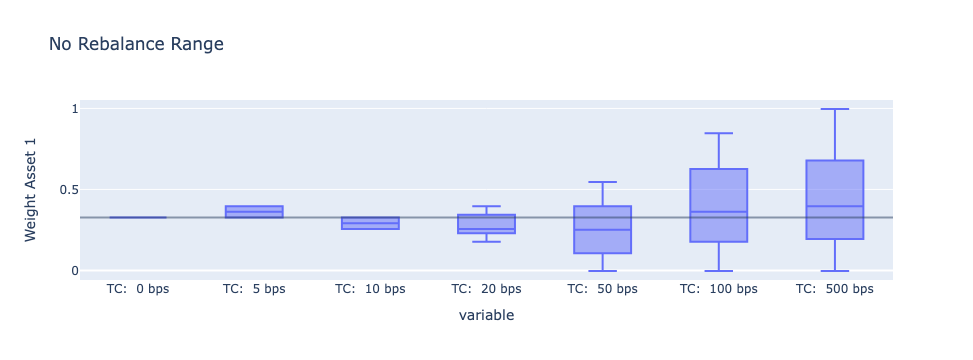

In [73]:
df = optimal_weight[0] + df
# Create a box plot using Plotly
fig = px.box(df, title="No Rebalance Range").update_layout(yaxis_title="Weight Asset 1")

fig.add_hline(y=optimal_weight[0], opacity=0.5)

# Show the plot
fig.show()

## 8 Assets

In [74]:
n_asset = 8
tc = 0.002
mu = np.linspace(50, 200, n_asset) / 1e4
sigma = np.linspace(300, 800, n_asset) / 1e4
cov = np.diag(sigma ** 2)

In [75]:
optimal_weight = find_optimal_wgt(mu, cov)
state = torch.Tensor(optimal_weight).unsqueeze(0)
optimal_weight

array([0.16397001, 0.15284272, 0.13978576, 0.12758588, 0.11680825,
       0.10743797, 0.09931577, 0.09225364])

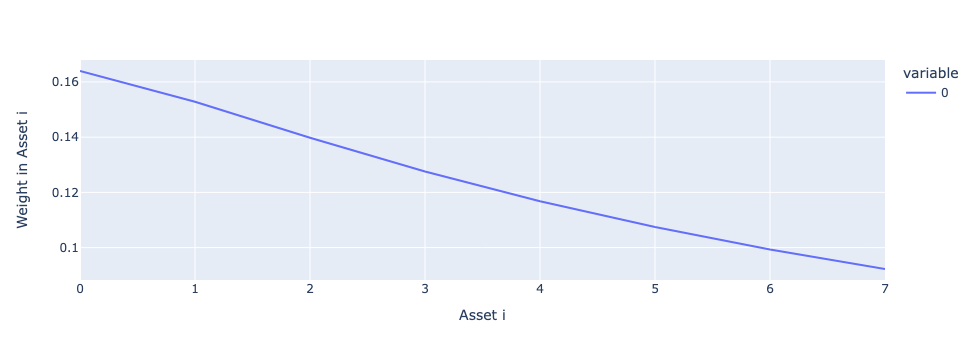

In [76]:
px.line(optimal_weight).update_layout(xaxis_title="Asset i", yaxis_title="Weight in Asset i")

In [77]:
tc = 0.002
a = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)
b = DQN(n_observations=n_asset, n_actions=2, name="Target", tc=tc).to(tmp_device)

load_models(pn=a, tn=b)

... loading checkpoint ...
... loading checkpoint ...


In [78]:
qval = a(torch.FloatTensor(state)).detach().numpy()
act = env.action_space[qval.argmax()]
if act.item() == 1:
    print(f"Action = {act.item()} -> You should rebalance! (tc = {tc * 1e4:.0f} bps)")
else:
    print(f"Action = {act.item()} -> You should NOT rebalance! (tc = {tc * 1e4:.0f} bps)")

Action = 0 -> You should NOT rebalance! (tc = 20 bps)


In [79]:
# og_tensor = torch.tensor([[0.1, 0.3, 0.3, 0.3]])
high_dim_tensors = get_high_dim_tensors(og_tensor=optimal_weight, w_optimal=optimal_weight, num_steps=20)
high_dim_tensors[:5]

[tensor([0.1640, 0.1528, 0.1398, 0.1276, 0.1168, 0.1074, 0.0993, 0.0923]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0.0000, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.2569, 0.1396, 0.1265, 0.1143, 0.1035, 0.0942, 0.0860, 0.0790])]

In [80]:
delta_weights_0 = [0] + [(-high_dim_tensors[0][0] + high_dim_tensors[1:][i][0]).item() for i in range(len(high_dim_tensors) - 1)]
delta_weights_0 = [round(i, 2) for i in delta_weights_0]
delta_weights_0[:5]

[0, 0.84, -0.16, -0.04, 0.09]

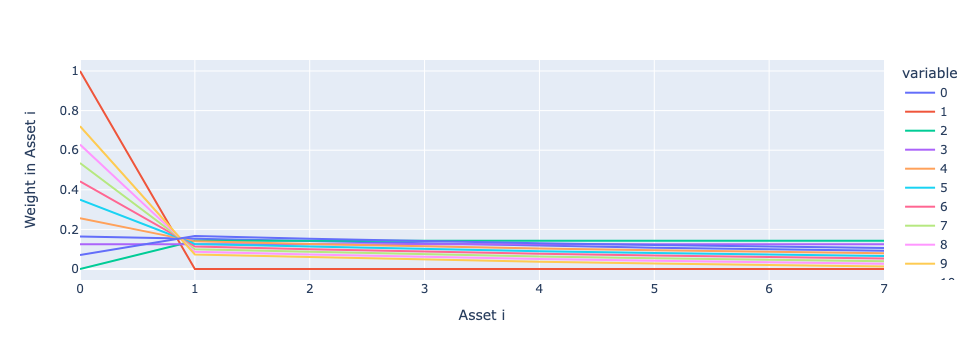

In [81]:
tmp = high_dim_tensors
tmp = [i.detach().numpy() for i in tmp]
df = pd.DataFrame(tmp).T
px.line(df).update_layout(xaxis_title="Asset i", yaxis_title="Weight in Asset i")

In [82]:
# out = []
# for i in high_dim_tensors:
#     qval = a(torch.FloatTensor(i)).detach().numpy()
#     act = env.action_space[qval.argmax()]
#     out.append(act.item())
#     if act.item() == 1:
#         print(f"Action = {act.item()} -> You should rebalance! (tc = {tc * 1e4:.0f} bps)")
#     else:
#         print(f"Action = {act.item()} -> You should NOT rebalance! (tc = {tc * 1e4:.0f} bps)")

In [83]:
out = {}
for tc in tc_list:
    a = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)
    b = DQN(n_observations=n_asset, n_actions=2, name="Target", tc=tc).to(tmp_device)
    
    load_models(pn=a, tn=b)
    tmp = []
    for i in high_dim_tensors:
        qval = a(torch.FloatTensor(i)).detach().numpy()
        act = env.action_space[qval.argmax()]
        tmp.append(act.item())

    out[f'TC:  {tc * 1e4:.0f} bps'] = tmp

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


In [84]:
df = pd.DataFrame(out, index=delta_weights_0)
df = df.sort_index()
df.head()

TC:  0 bps  TC:  5 bps  TC:  10 bps  TC:  20 bps  TC:  50 bps  \
-0.16           1           1            1            1            0   
-0.09           1           1            1            0            0   
-0.04           1           0            1            1            0   
 0.00           1           1            1            0            0   
 0.09           1           1            1            1            0   

       TC:  100 bps  TC:  500 bps  
-0.16             0             0  
-0.09             0             0  
-0.04             0             0  
 0.00             0             0  
 0.09             0             0

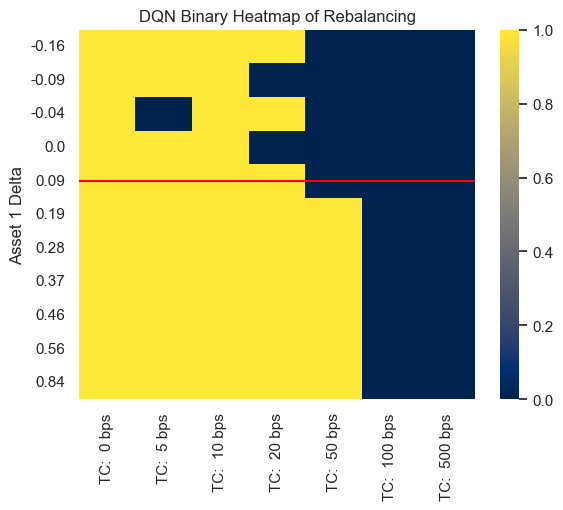

In [85]:
sns.heatmap(df, cmap='cividis')

ax = plt.gca()
plt.hlines(y=df.shape[0] // 2 - 1/2, xmin=0, xmax=len(dqn_action_df.columns), colors='red')
plt.title("DQN Binary Heatmap of Rebalancing")
plt.ylabel("Asset 1 Delta")
plt.show()

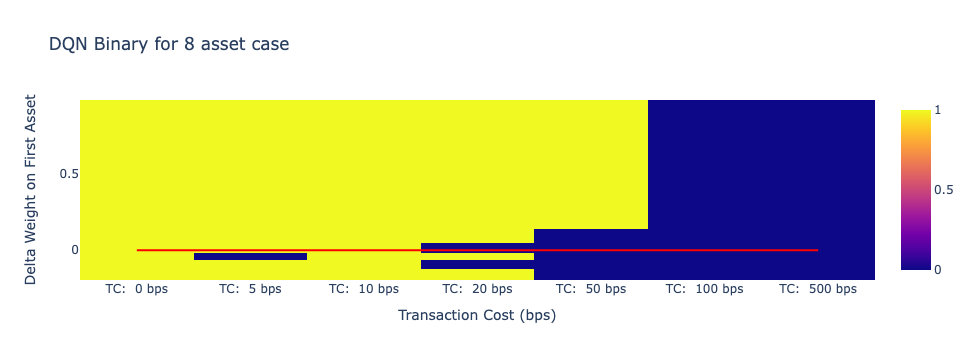

In [86]:
# Assuming `dqn_bool_action_df` and `bool_action_bm_df` are your DataFrames
dqn_df = df.copy()

# Create a heatmap trace for DQN Binary
trace_dqn = go.Heatmap(z=dqn_df, x=dqn_df.columns, y=dqn_df.index, name="DQN Binary")

# Create the layout with 'overlay' parameter set to "overlay"
layout = go.Layout(
    title=f"DQN Binary for {n_asset} asset case",
    xaxis=dict(title="Transaction Cost (bps)",
               showgrid=True),
    yaxis=dict(title="Delta Weight on First Asset",
               showgrid=True))

# Add horizontal line at y=0.50
layout.shapes = [
    dict(
        type="line",
        x0=dqn_df.columns[0],  # Adjust x0 to the starting point of your data
        x1=dqn_df.columns[-1],  # Adjust x1 to the ending point of your data
        y0=0,
        y1=0,
        line=dict(color="red", width=2),  # You can customize the color and width of the line
    )
]


fig = go.Figure(data=[trace_dqn], layout=layout)
fig.show()



In [87]:
dqn_noreb = {}
for col in df.columns:
    dqn_index = df[df[col] == 0].index.values
    dqn_noreb[col] = dqn_index

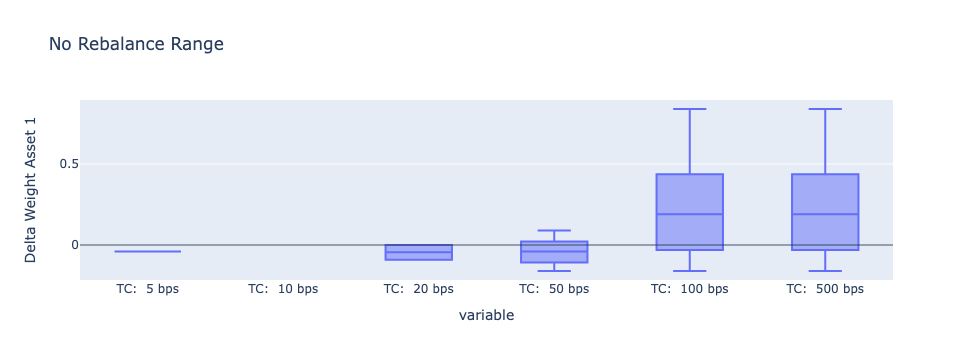

In [88]:
# Create a DataFrame from the dictionary, excluding keys with empty values
df = pd.DataFrame.from_dict(dqn_noreb, orient='index').T

# Create a box plot using Plotly
fig = px.box(df, title="No Rebalance Range").update_layout(yaxis_title="Delta Weight Asset 1")

fig.add_hline(y=0, opacity=0.5)
# Show the plot
fig.show()

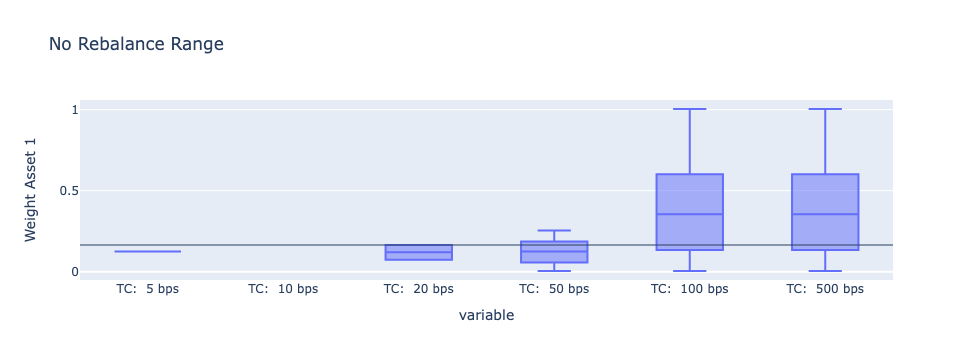

In [89]:
df = optimal_weight[0] + df
# Create a box plot using Plotly
fig = px.box(df, title="No Rebalance Range").update_layout(yaxis_title="Weight Asset 1")

fig.add_hline(y=optimal_weight[0], opacity=0.5)

# Show the plot
fig.show()

## 32 Assets

In [90]:
n_asset = 32
tc = 0.002
mu = np.linspace(50, 200, n_asset) / 1e4
sigma = np.linspace(300, 800, n_asset) / 1e4
cov = np.diag(sigma ** 2)

In [91]:
optimal_weight = find_optimal_wgt(mu, cov)
state = torch.Tensor(optimal_weight).unsqueeze(0)
optimal_weight

array([0.04102786, 0.04066223, 0.04002114, 0.0393469 , 0.03872601,
       0.03804007, 0.03724127, 0.03634512, 0.03555705, 0.03485426,
       0.03422818, 0.03350525, 0.03282634, 0.0321328 , 0.03141941,
       0.03083873, 0.03032973, 0.02962892, 0.0290934 , 0.02865538,
       0.02816096, 0.02748528, 0.02704373, 0.02656959, 0.02598976,
       0.02559782, 0.02520074, 0.02475413, 0.02423431, 0.02387018,
       0.02346884, 0.02314463])

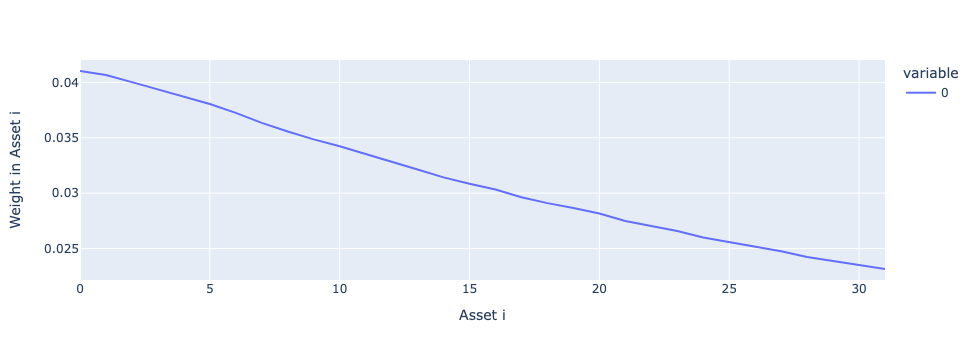

In [92]:
px.line(optimal_weight).update_layout(xaxis_title="Asset i", yaxis_title="Weight in Asset i")

In [93]:
tc = 0.002
a = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)
b = DQN(n_observations=n_asset, n_actions=2, name="Target", tc=tc).to(tmp_device)

load_models(pn=a, tn=b)

... loading checkpoint ...
... loading checkpoint ...


In [94]:
qval = a(torch.FloatTensor(state)).detach().numpy()
act = env.action_space[qval.argmax()]
if act.item() == 1:
    print(f"Action = {act.item()} -> You should rebalance! (tc = {tc * 1e4:.0f} bps)")
else:
    print(f"Action = {act.item()} -> You should NOT rebalance! (tc = {tc * 1e4:.0f} bps)")

Action = 1 -> You should rebalance! (tc = 20 bps)


In [95]:
# og_tensor = torch.tensor([[0.1, 0.3, 0.3, 0.3]])
high_dim_tensors = get_high_dim_tensors(og_tensor=optimal_weight, w_optimal=optimal_weight, num_steps=20)
# high_dim_tensors[:5]

In [96]:
delta_weights_0 = [0] + [(-high_dim_tensors[0][0] + high_dim_tensors[1:][i][0]).item() for i in range(len(high_dim_tensors) - 1)]
delta_weights_0 = [round(i, 2) for i in delta_weights_0]
delta_weights_0[:5]

[0, 0.96, -0.04, -0.01, 0.11]

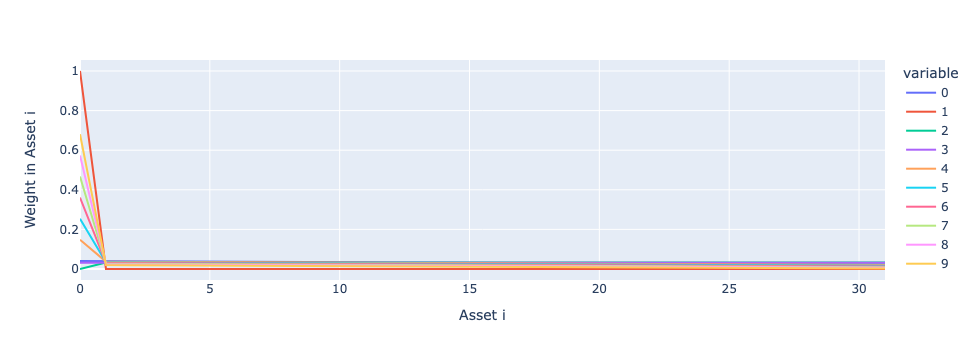

In [97]:
tmp = high_dim_tensors
tmp = [i.detach().numpy() for i in tmp]
df = pd.DataFrame(tmp).T
px.line(df).update_layout(xaxis_title="Asset i", yaxis_title="Weight in Asset i")

In [98]:
# out = []
# for i in high_dim_tensors:
#     qval = a(torch.FloatTensor(i)).detach().numpy()
#     act = env.action_space[qval.argmax()]
#     out.append(act.item())
#     if act.item() == 1:
#         print(f"Action = {act.item()} -> You should rebalance! (tc = {tc * 1e4:.0f} bps)")
#     else:
#         print(f"Action = {act.item()} -> You should NOT rebalance! (tc = {tc * 1e4:.0f} bps)")

In [99]:
out = {}
for tc in tc_list:
    a = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)
    b = DQN(n_observations=n_asset, n_actions=2, name="Target", tc=tc).to(tmp_device)
    
    load_models(pn=a, tn=b)
    tmp = []
    for i in high_dim_tensors:
        qval = a(torch.FloatTensor(i)).detach().numpy()
        act = env.action_space[qval.argmax()]
        tmp.append(act.item())

    out[f'TC:  {tc * 1e4:.0f} bps'] = tmp

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


In [100]:
df = pd.DataFrame(out, index=delta_weights_0)
df = df.sort_index()
df.head()

TC:  0 bps  TC:  5 bps  TC:  10 bps  TC:  20 bps  TC:  50 bps  \
-0.04           1           1            1            1            1   
-0.01           1           1            1            1            1   
 0.00           1           1            1            1            1   
 0.11           1           1            1            1            1   
 0.21           1           1            1            1            1   

       TC:  100 bps  TC:  500 bps  
-0.04             0             0  
-0.01             0             0  
 0.00             0             0  
 0.11             0             0  
 0.21             0             0

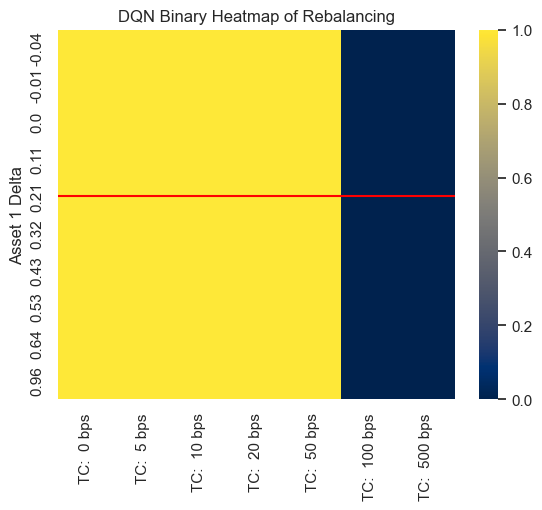

In [101]:
sns.heatmap(df, cmap='cividis')

ax = plt.gca()
plt.hlines(y=df.shape[0] // 2 - 1/2, xmin=0, xmax=len(dqn_action_df.columns), colors='red')
plt.title("DQN Binary Heatmap of Rebalancing")
plt.ylabel("Asset 1 Delta")
plt.show()

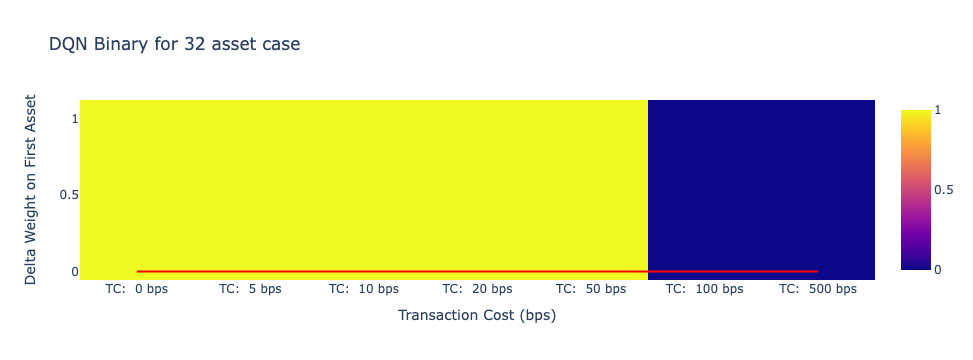

In [102]:
# Assuming `dqn_bool_action_df` and `bool_action_bm_df` are your DataFrames
dqn_df = df.copy()

# Create a heatmap trace for DQN Binary
trace_dqn = go.Heatmap(z=dqn_df, x=dqn_df.columns, y=dqn_df.index, name="DQN Binary")

# Create the layout with 'overlay' parameter set to "overlay"
layout = go.Layout(
    title=f"DQN Binary for {n_asset} asset case",
    xaxis=dict(title="Transaction Cost (bps)",
               showgrid=True),
    yaxis=dict(title="Delta Weight on First Asset",
               showgrid=True))

# Add horizontal line at y=0.50
layout.shapes = [
    dict(
        type="line",
        x0=dqn_df.columns[0],  # Adjust x0 to the starting point of your data
        x1=dqn_df.columns[-1],  # Adjust x1 to the ending point of your data
        y0=0,
        y1=0,
        line=dict(color="red", width=2),  # You can customize the color and width of the line
    )
]


fig = go.Figure(data=[trace_dqn], layout=layout)
fig.show()



In [103]:
dqn_noreb = {}
for col in df.columns:
    dqn_index = df[df[col] == 0].index.values
    dqn_noreb[col] = dqn_index

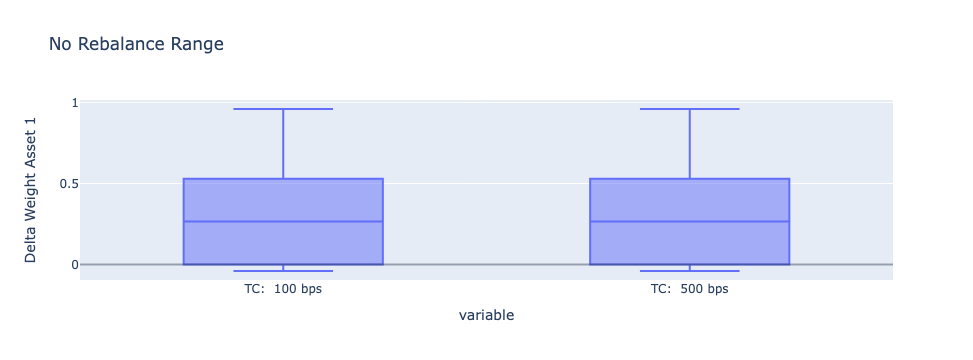

In [104]:
# Create a DataFrame from the dictionary, excluding keys with empty values
df = pd.DataFrame.from_dict(dqn_noreb, orient='index').T

# Create a box plot using Plotly
fig = px.box(df, title="No Rebalance Range").update_layout(yaxis_title="Delta Weight Asset 1")

fig.add_hline(y=0, opacity=0.5)

# Show the plot
fig.show()

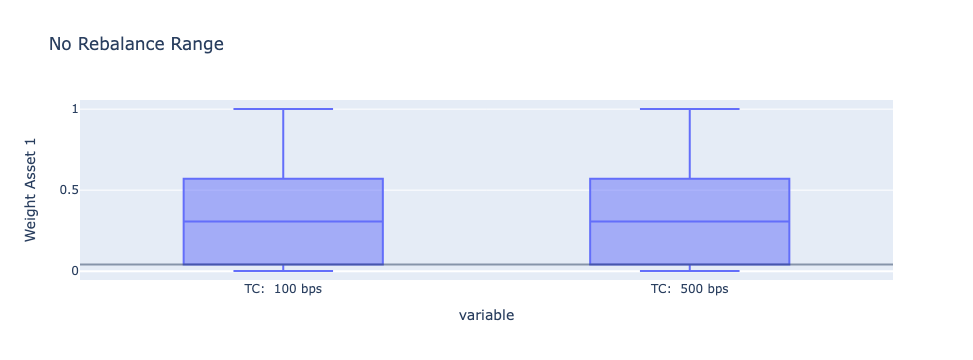

In [105]:
df = optimal_weight[0] + df
# Create a box plot using Plotly
fig = px.box(df, title="No Rebalance Range").update_layout(yaxis_title="Weight Asset 1")

fig.add_hline(y=optimal_weight[0], opacity=0.5)

# Show the plot
fig.show()

## 128 Assets

In [106]:
n_asset = 128
tc = 0.002
mu = np.linspace(50, 200, n_asset) / 1e4
sigma = np.linspace(300, 800, n_asset) / 1e4
cov = np.diag(sigma ** 2)

In [107]:
optimal_weight = find_optimal_wgt(mu, cov)
state = torch.Tensor(optimal_weight).unsqueeze(0)
optimal_weight

array([0.01030032, 0.01026874, 0.0102351 , 0.01019999, 0.01015836,
       0.01011764, 0.01008986, 0.01006435, 0.01003273, 0.00998189,
       0.00992997, 0.00986711, 0.00982988, 0.00981876, 0.00980386,
       0.009668  , 0.00971094, 0.00966285, 0.00962645, 0.00957045,
       0.0095194 , 0.00947477, 0.00943105, 0.00938341, 0.00933421,
       0.00927285, 0.0092347 , 0.00919611, 0.00915948, 0.00911221,
       0.00906387, 0.00901944, 0.00898048, 0.00892033, 0.00887741,
       0.00883663, 0.008759  , 0.00873525, 0.00870883, 0.00866399,
       0.00858814, 0.00857598, 0.00851905, 0.00849203, 0.00845354,
       0.00838181, 0.00836874, 0.0083113 , 0.00825746, 0.00824474,
       0.00820857, 0.0081263 , 0.00810299, 0.00805263, 0.00804497,
       0.0079946 , 0.00795563, 0.00792468, 0.00786995, 0.00784115,
       0.00779695, 0.00775391, 0.00770878, 0.0076877 , 0.00762462,
       0.00759412, 0.00755295, 0.00749933, 0.00746997, 0.0074338 ,
       0.00739894, 0.00737043, 0.00733722, 0.00730794, 0.00726

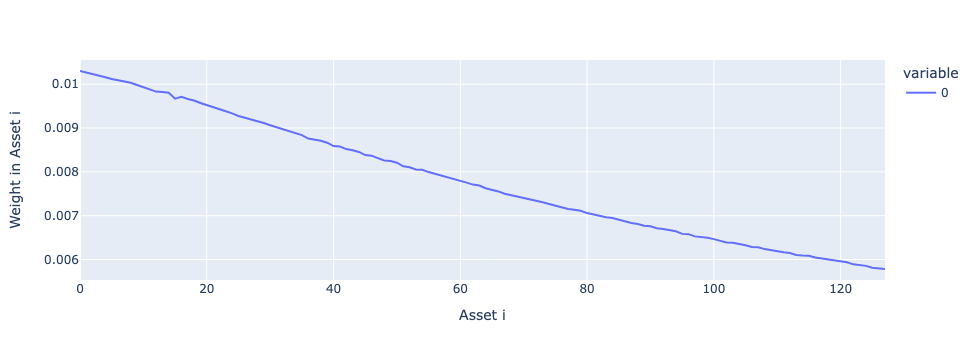

In [108]:
px.line(optimal_weight).update_layout(xaxis_title="Asset i", yaxis_title="Weight in Asset i")

In [109]:
tc = 0.002
a = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)
b = DQN(n_observations=n_asset, n_actions=2, name="Target", tc=tc).to(tmp_device)

load_models(pn=a, tn=b)

... loading checkpoint ...
... loading checkpoint ...


In [110]:
qval = a(torch.FloatTensor(state)).detach().numpy()
act = env.action_space[qval.argmax()]
if act.item() == 1:
    print(f"Action = {act.item()} -> You should rebalance! (tc = {tc * 1e4:.0f} bps)")
else:
    print(f"Action = {act.item()} -> You should NOT rebalance! (tc = {tc * 1e4:.0f} bps)")

Action = 1 -> You should rebalance! (tc = 20 bps)


In [111]:
# og_tensor = torch.tensor([[0.1, 0.3, 0.3, 0.3]])
high_dim_tensors = get_high_dim_tensors(og_tensor=optimal_weight, w_optimal=optimal_weight, num_steps=20)
# high_dim_tensors[:5]

In [112]:
delta_weights_0 = [0] + [(-high_dim_tensors[0][0] + high_dim_tensors[1:][i][0]).item() for i in range(len(high_dim_tensors) - 1)]
delta_weights_0 = [round(i, 2) for i in delta_weights_0]
delta_weights_0[:5]

[0, 0.99, -0.01, -0.0, 0.11]

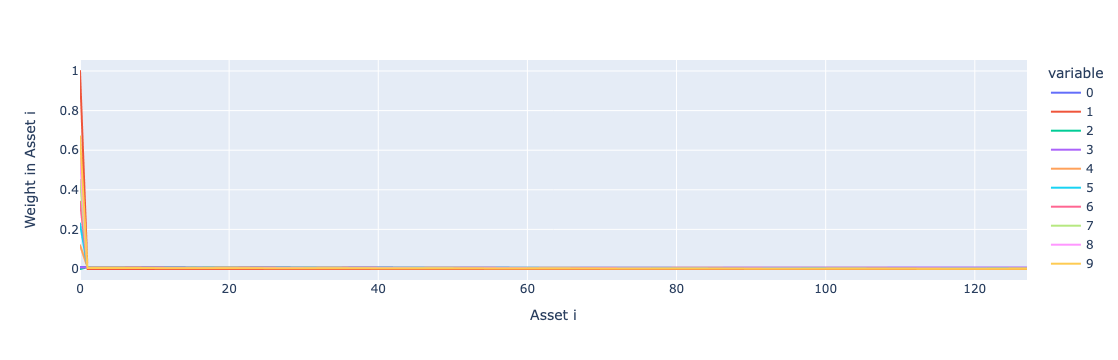

In [113]:
tmp = high_dim_tensors
tmp = [i.detach().numpy() for i in tmp]
df = pd.DataFrame(tmp).T
px.line(df).update_layout(xaxis_title="Asset i", yaxis_title="Weight in Asset i")

In [114]:
# out = []
# for i in high_dim_tensors:
#     qval = a(torch.FloatTensor(i)).detach().numpy()
#     act = env.action_space[qval.argmax()]
#     out.append(act.item())
#     if act.item() == 1:
#         print(f"Action = {act.item()} -> You should rebalance! (tc = {tc * 1e4:.0f} bps)")
#     else:
#         print(f"Action = {act.item()} -> You should NOT rebalance! (tc = {tc * 1e4:.0f} bps)")

In [115]:
out = {}
for tc in tc_list:
    a = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)
    b = DQN(n_observations=n_asset, n_actions=2, name="Target", tc=tc).to(tmp_device)
    
    load_models(pn=a, tn=b)
    tmp = []
    for i in high_dim_tensors:
        qval = a(torch.FloatTensor(i)).detach().numpy()
        act = env.action_space[qval.argmax()]
        tmp.append(act.item())

    out[f'TC:  {tc * 1e4:.0f} bps'] = tmp

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


In [116]:
df = pd.DataFrame(out, index=delta_weights_0)
df = df.sort_index()
df.head()

TC:  0 bps  TC:  5 bps  TC:  10 bps  TC:  20 bps  TC:  50 bps  \
-0.01           1           1            1            1            1   
 0.00           1           1            1            1            1   
-0.00           1           1            1            1            1   
 0.11           1           1            1            1            1   
 0.22           1           1            1            1            1   

       TC:  100 bps  TC:  500 bps  
-0.01             0             0  
 0.00             0             0  
-0.00             0             0  
 0.11             1             0  
 0.22             1             0

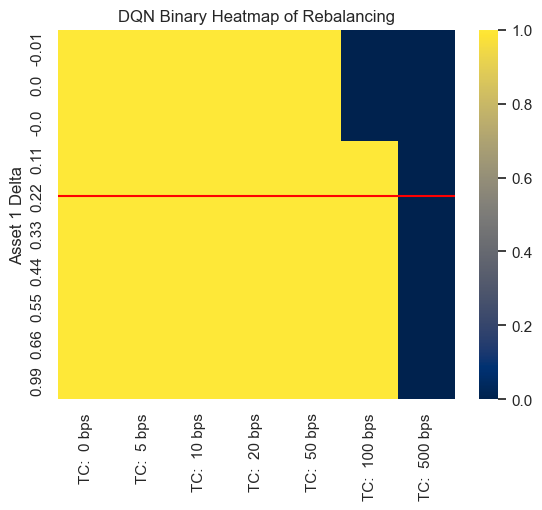

In [117]:
sns.heatmap(df, cmap='cividis')

ax = plt.gca()
plt.hlines(y=df.shape[0] // 2 - 1/2, xmin=0, xmax=len(dqn_action_df.columns), colors='red')
plt.title("DQN Binary Heatmap of Rebalancing")
plt.ylabel("Asset 1 Delta")
plt.show()

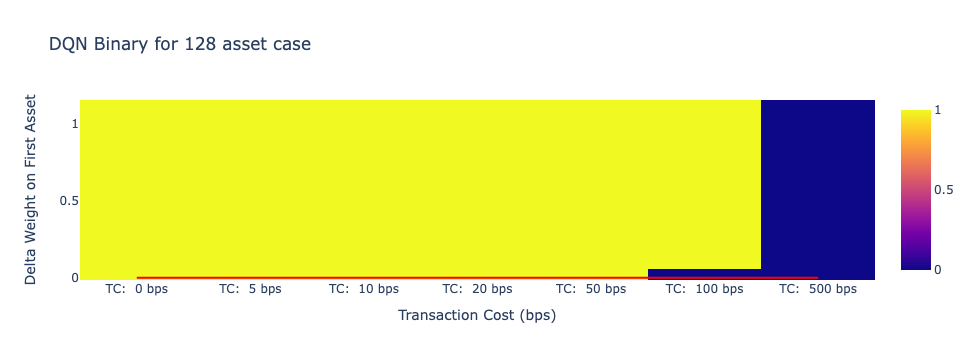

In [118]:
# Assuming `dqn_bool_action_df` and `bool_action_bm_df` are your DataFrames
dqn_df = df.copy()

# Create a heatmap trace for DQN Binary
trace_dqn = go.Heatmap(z=dqn_df, x=dqn_df.columns, y=dqn_df.index, name="DQN Binary")

# Create the layout with 'overlay' parameter set to "overlay"
layout = go.Layout(
    title=f"DQN Binary for {n_asset} asset case",
    xaxis=dict(title="Transaction Cost (bps)",
               showgrid=True),
    yaxis=dict(title="Delta Weight on First Asset",
               showgrid=True))

# Add horizontal line at y=0.50
layout.shapes = [
    dict(
        type="line",
        x0=dqn_df.columns[0],  # Adjust x0 to the starting point of your data
        x1=dqn_df.columns[-1],  # Adjust x1 to the ending point of your data
        y0=0,
        y1=0,
        line=dict(color="red", width=2),  # You can customize the color and width of the line
    )
]


fig = go.Figure(data=[trace_dqn], layout=layout)
fig.show()



In [119]:
dqn_noreb = {}
for col in df.columns:
    dqn_index = df[df[col] == 0].index.values
    dqn_noreb[col] = dqn_index

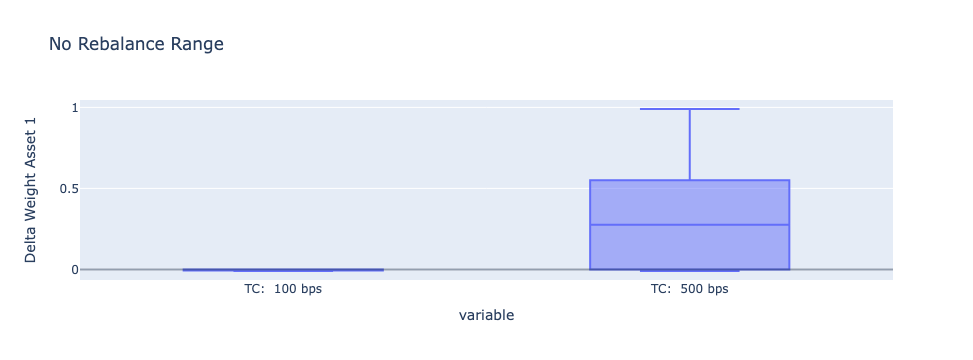

In [120]:
# Create a DataFrame from the dictionary, excluding keys with empty values
df = pd.DataFrame.from_dict(dqn_noreb, orient='index').T

# Create a box plot using Plotly
fig = px.box(df, title="No Rebalance Range").update_layout(yaxis_title="Delta Weight Asset 1")

fig.add_hline(y=0, opacity=0.5)

# Show the plot
fig.show()

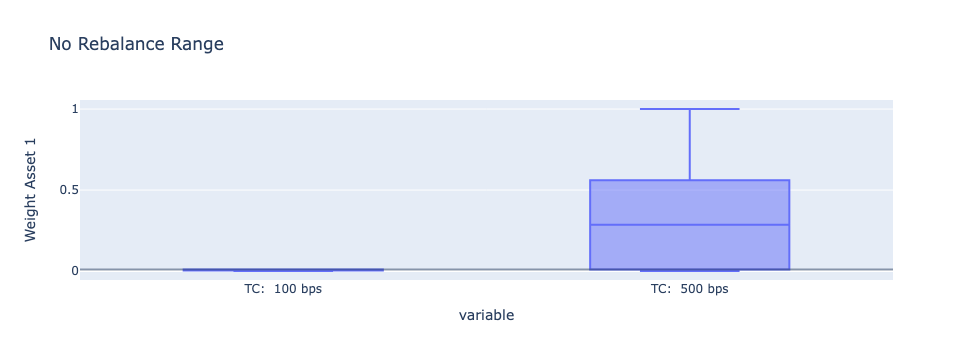

In [121]:
df = optimal_weight[0] + df
# Create a box plot using Plotly
fig = px.box(df, title="No Rebalance Range").update_layout(yaxis_title="Weight Asset 1")

fig.add_hline(y=optimal_weight[0], opacity=0.5)

# Show the plot
fig.show()